<a href="https://colab.research.google.com/github/PYFTS/notebooks/blob/master/Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of Computational Experiments

## For running on Colab

In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
!git clone https://github.com/petroniocandido/stac

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-lukq3tuz
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-lukq3tuz
  Created wheel for pyFTS: filename=pyFTS-1.6-cp36-none-any.whl size=197025 sha256=448e215310ef7105063c398960ff3cbb516aea5106191a318d861fb67cfc5ae7
  Stored in directory: /tmp/pip-ephem-wheel-cache-iklubsrn/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS
Cloning into 'stac'...
remote: Enumerating objects: 2238, done.
remote: Total 2238 (delta 0), reused 0 (delta 0), pack-reused 2238
Receiving objects: 100% (2238/2238), 23.62 MiB | 21.66 MiB/s, done.
Resolving deltas: 100% (1147/1147), done.


## Common Imports

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Common data transformations

In [0]:
from pyFTS.common import Transformations

tdiff = Transformations.Differential(1)

boxcox = Transformations.BoxCox(0)

## Import Datasets

In [0]:
from pyFTS.data import TAIEX, NASDAQ, SP500

dataset_names = ["TAIEX", "SP500","NASDAQ"]

def get_dataset(name):
    if dataset_name == "TAIEX":
        return TAIEX.get_data()
    elif dataset_name == "SP500":
        return SP500.get_data()[11500:16000]
    elif dataset_name == "NASDAQ":
        return NASDAQ.get_data()


train_split = 2000
test_length = 200

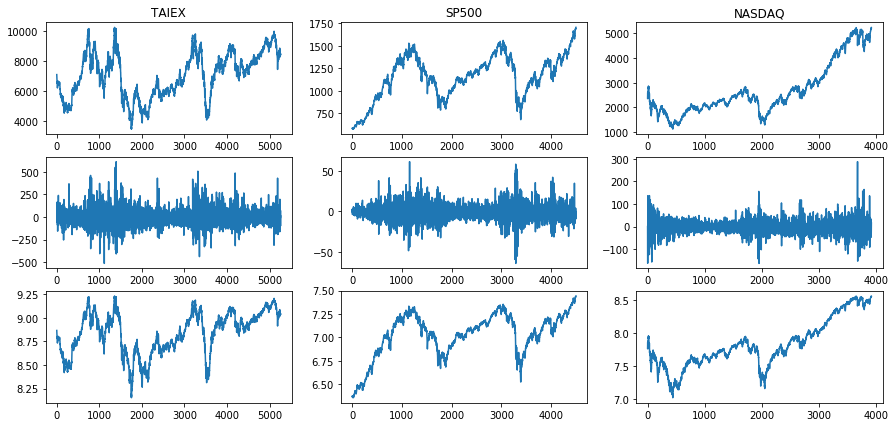

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[15,7])

for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)
    dataset_diff = tdiff.apply(dataset)
    dataset_boxcox = boxcox.apply(dataset)

    ax[0][count].plot(dataset)
    ax[1][count].plot(dataset_diff)
    ax[2][count].plot(dataset_boxcox)
    ax[0][count].set_title(dataset_name)

## Batch computational experiments with sliding_window_benchmarks

The **benchmarks.sliding_window_benchmarks** is a method that executes sliding window experiments on batch, for several models, partitioners, number of partitions, transformations, etc, and store its results on a Sqlite3 database for posterior analysis. 

The default file database name is 'benchmarks.db', and it contains a table named 'benchmarks' with the below schema:

 - ID: integer incremental primary key
 - Date: Date/hour of benchmark execution
 - Dataset: Identify on which dataset the dataset was performed
 - Tag: a user defined word that indentify a benchmark set 
 - Type: forecasting type (point, interval, distribution)
 - Model: FTS model
 - Transformation: The name of data transformation, if one was used
 - Order: the order of the FTS method  
 - Scheme: UoD partitioning scheme
 - Partitions: Number of partitions
 - Size: Number of rules of the FTS model  
 - Steps: prediction horizon, i. e., the number of steps ahead
 - Measure: accuracy measure
 - Value: the measure value

Know the sliding_window_benchmarks options:

In [0]:
from pyFTS.benchmarks import benchmarks as bchmk
help(bchmk.sliding_window_benchmarks)

Help on function sliding_window_benchmarks in module pyFTS.benchmarks.benchmarks:

sliding_window_benchmarks(data, windowsize, train=0.8, **kwargs)
    Sliding window benchmarks for FTS forecasters.
    
    For each data window, a train and test datasets will be splitted. For each train split, number of
    partitions and partitioning method will be created a partitioner model. And for each partitioner, order,
    steps ahead and FTS method a foreasting model will be trained.
    
    Then all trained models are benchmarked on the test data and the metrics are stored on a sqlite3 database
    (identified by the 'file' parameter) for posterior analysis.
    
    All these process can be distributed on a dispy cluster, setting the atributed 'distributed' to true and
    informing the list of dispy nodes on 'nodes' parameter.
    
    The number of experiments is determined by 'windowsize' and 'inc' parameters.
    
    :param data: test data
    :param windowsize: size of sliding window

## Partitioning optimization by dataset

**CAUTION**: This task is computationally expensive and take several hours to be performed. We strongly recommend to use the distributed version with a dispy cluster.

In [0]:
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.benchmarks import benchmarks as bchmk
from pyFTS.models import chen

tag = 'chen_partitioning'
_type = 'point'

for dataset_name in dataset_names:
    dataset = get_dataset(dataset_name)

    bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                    methods=[chen.ConventionalFTS],
                                    benchmark_models=False,
                                    transformations=[None],
                                    partitions=np.arange(10,100,2), 
                                    progress=False, type=_type,
                                    distributed=True, nodes=['192.168.0.110', '192.168.0.107','192.168.0.106'],
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)

    bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                    methods=[chen.ConventionalFTS],
                                    benchmark_models=False,
                                    transformations=[tdiff],
                                    partitions=np.arange(3,30,1), 
                                    progress=False, type=_type,
                                    distributed=True, nodes=['192.168.0.110', '192.168.0.107', '192.168.0.106'],
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)


2018-05-14 16:40:47 pycos - version 4.6.5 with epoll I/O notifier
2018-05-14 16:40:47 dispy - dispy client version: 4.8.5
2018-05-14 16:40:47 dispy - Storing fault recovery information in "_dispy_20180514164047"
2018-05-14 16:40:48 dispy - Started HTTP server at ('0.0.0.0', 8181)
2018-05-14 16:40:48 dispy - dispy client at 127.0.0.1:51347
2018-05-14 16:40:48 dispy - Discovered 192.168.0.110:51348 (petronio-notebook) with 3 cpus
2018-05-14 16:40:48 dispy - Running job 140142391887816 on 192.168.0.110
2018-05-14 16:40:48 dispy - Running job 140142391887936 on 192.168.0.110
2018-05-14 16:40:48 dispy - Running job 140142391888056 on 192.168.0.110
2018-05-14 16:40:48 dispy - Running job <built-in function id> / 140142391887816 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:40:48 dispy - Running job <built-in function id> / 140142391887936 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:40:48 dispy - Running job <built-in function id> / 140142391888056 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16

2018-05-14 16:41:01 dispy - Received reply for job <built-in function id> / 140142379463688 from 192.168.0.110
2018-05-14 16:41:01 dispy - Running job 140142379464168 on 192.168.0.110
2018-05-14 16:41:01 dispy - Running job <built-in function id> / 140142379464168 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:03 dispy - Received reply for job <built-in function id> / 140142379464168 from 192.168.0.110
2018-05-14 16:41:03 dispy - Running job 140142379464288 on 192.168.0.110
2018-05-14 16:41:03 dispy - Running job <built-in function id> / 140142379464288 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:03 dispy - Received reply for job <built-in function id> / 140142379463928 from 192.168.0.110
2018-05-14 16:41:03 dispy - Running job 140142379464408 on 192.168.0.110
2018-05-14 16:41:03 dispy - Running job <built-in function id> / 140142379464408 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:03 dispy - Received reply for job <built-in function id> / 140142379464048 from 192.168.0.110
2

2018-05-14 16:41:16 dispy - Received reply for job <built-in function id> / 140142377492552 from 192.168.0.110
2018-05-14 16:41:16 dispy - Running job 140142377492912 on 192.168.0.110
2018-05-14 16:41:16 dispy - Running job <built-in function id> / 140142377492912 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:17 dispy - Received reply for job <built-in function id> / 140142377492672 from 192.168.0.110
2018-05-14 16:41:17 dispy - Running job 140142377493032 on 192.168.0.110
2018-05-14 16:41:17 dispy - Running job <built-in function id> / 140142377493032 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:17 dispy - Received reply for job <built-in function id> / 140142377492792 from 192.168.0.110
2018-05-14 16:41:17 dispy - Running job 140142377493152 on 192.168.0.110
2018-05-14 16:41:17 dispy - Running job <built-in function id> / 140142377493152 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:17 dispy - Received reply for job <built-in function id> / 140142377492912 from 192.168.0.110
2

2018-05-14 16:41:31 dispy - Received reply for job <built-in function id> / 140142377495912 from 192.168.0.110
2018-05-14 16:41:31 dispy - Running job 140142377496272 on 192.168.0.110
2018-05-14 16:41:31 dispy - Running job <built-in function id> / 140142377496272 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:31 dispy - Received reply for job <built-in function id> / 140142377496032 from 192.168.0.110
2018-05-14 16:41:31 dispy - Running job 140142377496392 on 192.168.0.110
2018-05-14 16:41:31 dispy - Running job <built-in function id> / 140142377496392 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:32 dispy - Received reply for job <built-in function id> / 140142377496152 from 192.168.0.110
2018-05-14 16:41:32 dispy - Running job 140142376026184 on 192.168.0.110
2018-05-14 16:41:32 dispy - Running job <built-in function id> / 140142376026184 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:33 dispy - Received reply for job <built-in function id> / 140142377496272 from 192.168.0.110
2

2018-05-14 16:41:44 dispy - Received reply for job <built-in function id> / 140142376028944 from 192.168.0.110
2018-05-14 16:41:44 dispy - Running job 140142376029304 on 192.168.0.110
2018-05-14 16:41:44 dispy - Running job <built-in function id> / 140142376029304 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:45 dispy - Received reply for job <built-in function id> / 140142376029064 from 192.168.0.110
2018-05-14 16:41:45 dispy - Running job 140142376029424 on 192.168.0.110
2018-05-14 16:41:45 dispy - Running job <built-in function id> / 140142376029424 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:45 dispy - Received reply for job <built-in function id> / 140142376029184 from 192.168.0.110
2018-05-14 16:41:45 dispy - Running job 140142376029544 on 192.168.0.110
2018-05-14 16:41:45 dispy - Running job <built-in function id> / 140142376029544 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:41:45 dispy - Received reply for job <built-in function id> / 140142376029304 from 192.168.0.110
2

2018-05-14 16:42:00 dispy - Received reply for job <built-in function id> / 140142374689072 from 192.168.0.110
2018-05-14 16:42:00 dispy - Running job 140142374689432 on 192.168.0.110
2018-05-14 16:42:00 dispy - Running job <built-in function id> / 140142374689432 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:00 dispy - Received reply for job <built-in function id> / 140142374689192 from 192.168.0.110
2018-05-14 16:42:00 dispy - Running job 140142374689552 on 192.168.0.110
2018-05-14 16:42:00 dispy - Running job <built-in function id> / 140142374689552 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:00 dispy - Received reply for job <built-in function id> / 140142374689312 from 192.168.0.110
2018-05-14 16:42:00 dispy - Running job 140142374689672 on 192.168.0.110
2018-05-14 16:42:00 dispy - Running job <built-in function id> / 140142374689672 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:01 dispy - Received reply for job <built-in function id> / 140142374689432 from 192.168.0.110
2

2018-05-14 16:42:13 dispy - Received reply for job <built-in function id> / 140142373533400 from 192.168.0.110
2018-05-14 16:42:13 dispy - Running job 140142373533760 on 192.168.0.110
2018-05-14 16:42:13 dispy - Running job <built-in function id> / 140142373533760 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:13 dispy - Received reply for job <built-in function id> / 140142373533520 from 192.168.0.110
2018-05-14 16:42:13 dispy - Running job 140142373533880 on 192.168.0.110
2018-05-14 16:42:13 dispy - Running job <built-in function id> / 140142373533880 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:14 dispy - Received reply for job <built-in function id> / 140142373533640 from 192.168.0.110
2018-05-14 16:42:14 dispy - Running job 140142373534000 on 192.168.0.110
2018-05-14 16:42:14 dispy - Running job <built-in function id> / 140142373534000 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:15 dispy - Received reply for job <built-in function id> / 140142373533880 from 192.168.0.110
2

2018-05-14 16:42:26 dispy - Received reply for job <built-in function id> / 140142371558528 from 192.168.0.110
2018-05-14 16:42:26 dispy - Running job 140142371558888 on 192.168.0.110
2018-05-14 16:42:26 dispy - Running job <built-in function id> / 140142371558888 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:27 dispy - Received reply for job <built-in function id> / 140142371558648 from 192.168.0.110
2018-05-14 16:42:27 dispy - Running job 140142371559008 on 192.168.0.110
2018-05-14 16:42:27 dispy - Running job <built-in function id> / 140142371559008 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:27 dispy - Received reply for job <built-in function id> / 140142371558768 from 192.168.0.110
2018-05-14 16:42:27 dispy - Running job 140142371559128 on 192.168.0.110
2018-05-14 16:42:27 dispy - Running job <built-in function id> / 140142371559128 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:27 dispy - Received reply for job <built-in function id> / 140142371558888 from 192.168.0.110
2

2018-05-14 16:42:42 dispy - Received reply for job <built-in function id> / 140142370361896 from 192.168.0.110
2018-05-14 16:42:42 dispy - Running job 140142370362256 on 192.168.0.110
2018-05-14 16:42:42 dispy - Running job <built-in function id> / 140142370362256 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:42 dispy - Received reply for job <built-in function id> / 140142370362136 from 192.168.0.110
2018-05-14 16:42:42 dispy - Running job 140142370362376 on 192.168.0.110
2018-05-14 16:42:42 dispy - Running job <built-in function id> / 140142370362376 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:42 dispy - Received reply for job <built-in function id> / 140142370362256 from 192.168.0.110
2018-05-14 16:42:42 dispy - Running job 140142370362496 on 192.168.0.110
2018-05-14 16:42:42 dispy - Running job <built-in function id> / 140142370362496 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:43 dispy - Received reply for job <built-in function id> / 140142370362016 from 192.168.0.110
2

2018-05-14 16:42:54 dispy - Received reply for job <built-in function id> / 140142370365256 from 192.168.0.110
2018-05-14 16:42:54 dispy - Running job 140142369079608 on 192.168.0.110
2018-05-14 16:42:54 dispy - Running job <built-in function id> / 140142369079608 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:55 dispy - Received reply for job <built-in function id> / 140142369079488 from 192.168.0.110
2018-05-14 16:42:55 dispy - Running job 140142369079728 on 192.168.0.110
2018-05-14 16:42:55 dispy - Running job <built-in function id> / 140142369079728 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:55 dispy - Received reply for job <built-in function id> / 140142369079368 from 192.168.0.110
2018-05-14 16:42:55 dispy - Running job 140142369079848 on 192.168.0.110
2018-05-14 16:42:55 dispy - Running job <built-in function id> / 140142369079848 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:42:56 dispy - Received reply for job <built-in function id> / 140142369079608 from 192.168.0.110
2

2018-05-14 16:43:09 dispy - Running job 140142369082968 on 192.168.0.110
2018-05-14 16:43:09 dispy - Running job <built-in function id> / 140142369082968 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:09 dispy - Received reply for job <built-in function id> / 140142369082728 from 192.168.0.110
2018-05-14 16:43:09 dispy - Running job 140142369083088 on 192.168.0.110
2018-05-14 16:43:09 dispy - Running job <built-in function id> / 140142369083088 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:10 dispy - Received reply for job <built-in function id> / 140142369082848 from 192.168.0.110
2018-05-14 16:43:10 dispy - Running job 140142369083208 on 192.168.0.110
2018-05-14 16:43:10 dispy - Running job <built-in function id> / 140142369083208 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:10 dispy - Received reply for job <built-in function id> / 140142369082968 from 192.168.0.110
2018-05-14 16:43:10 dispy - Running job 140142367461448 on 192.168.0.110
2018-05-14 16:43:10 dispy - Running job

2018-05-14 16:43:24 dispy - Received reply for job <built-in function id> / 140142367464208 from 192.168.0.110
2018-05-14 16:43:24 dispy - Running job 140142367464568 on 192.168.0.110
2018-05-14 16:43:24 dispy - Running job <built-in function id> / 140142367464568 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:26 dispy - Received reply for job <built-in function id> / 140142367464328 from 192.168.0.110
2018-05-14 16:43:26 dispy - Running job 140142367464688 on 192.168.0.110
2018-05-14 16:43:26 dispy - Running job <built-in function id> / 140142367464688 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:26 dispy - Received reply for job <built-in function id> / 140142367464448 from 192.168.0.110
2018-05-14 16:43:26 dispy - Running job 140142367464808 on 192.168.0.110
2018-05-14 16:43:26 dispy - Running job <built-in function id> / 140142367464808 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:27 dispy - Received reply for job <built-in function id> / 140142367464568 from 192.168.0.110
2

2018-05-14 16:43:38 dispy - Received reply for job <built-in function id> / 140142164162864 from 192.168.0.110
2018-05-14 16:43:38 dispy - Running job 140142164163104 on 192.168.0.110
2018-05-14 16:43:38 dispy - Running job <built-in function id> / 140142164163104 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:38 dispy - Received reply for job <built-in function id> / 140142164162744 from 192.168.0.110
2018-05-14 16:43:38 dispy - Running job 140142164163224 on 192.168.0.110
2018-05-14 16:43:38 dispy - Running job <built-in function id> / 140142164163224 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:39 dispy - Received reply for job <built-in function id> / 140142164162984 from 192.168.0.110
2018-05-14 16:43:39 dispy - Running job 140142164163344 on 192.168.0.110
2018-05-14 16:43:39 dispy - Running job <built-in function id> / 140142164163344 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:39 dispy - Received reply for job <built-in function id> / 140142164163104 from 192.168.0.110
2

2018-05-14 16:43:55 dispy - Received reply for job <built-in function id> / 140142162835160 from 192.168.0.110
2018-05-14 16:43:55 dispy - Running job 140142162835400 on 192.168.0.110
2018-05-14 16:43:55 dispy - Running job <built-in function id> / 140142162835400 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:55 dispy - Received reply for job <built-in function id> / 140142162835040 from 192.168.0.110
2018-05-14 16:43:55 dispy - Running job 140142162835520 on 192.168.0.110
2018-05-14 16:43:55 dispy - Running job <built-in function id> / 140142162835520 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:55 dispy - Received reply for job <built-in function id> / 140142162835280 from 192.168.0.110
2018-05-14 16:43:55 dispy - Running job 140142162835640 on 192.168.0.110
2018-05-14 16:43:55 dispy - Running job <built-in function id> / 140142162835640 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:43:56 dispy - Received reply for job <built-in function id> / 140142162835520 from 192.168.0.110
2

2018-05-14 16:44:09 dispy - Received reply for job <built-in function id> / 140142161540104 from 192.168.0.110
2018-05-14 16:44:09 dispy - Running job 140142161540464 on 192.168.0.110
2018-05-14 16:44:09 dispy - Running job <built-in function id> / 140142161540464 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:09 dispy - Received reply for job <built-in function id> / 140142161540224 from 192.168.0.110
2018-05-14 16:44:09 dispy - Running job 140142161540584 on 192.168.0.110
2018-05-14 16:44:09 dispy - Running job <built-in function id> / 140142161540584 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:10 dispy - Received reply for job <built-in function id> / 140142161540344 from 192.168.0.110
2018-05-14 16:44:10 dispy - Running job 140142161540704 on 192.168.0.110
2018-05-14 16:44:10 dispy - Running job <built-in function id> / 140142161540704 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:10 dispy - Received reply for job <built-in function id> / 140142161540584 from 192.168.0.110
2

2018-05-14 16:44:24 dispy - Received reply for job <built-in function id> / 140142160015792 from 192.168.0.110
2018-05-14 16:44:24 dispy - Running job 140142160016152 on 192.168.0.110
2018-05-14 16:44:24 dispy - Running job <built-in function id> / 140142160016152 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:24 dispy - Received reply for job <built-in function id> / 140142160015912 from 192.168.0.110
2018-05-14 16:44:24 dispy - Running job 140142160016272 on 192.168.0.110
2018-05-14 16:44:24 dispy - Running job <built-in function id> / 140142160016272 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:24 dispy - Received reply for job <built-in function id> / 140142160016032 from 192.168.0.110
2018-05-14 16:44:24 dispy - Running job 140142160016392 on 192.168.0.110
2018-05-14 16:44:24 dispy - Running job <built-in function id> / 140142160016392 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:25 dispy - Received reply for job <built-in function id> / 140142160016392 from 192.168.0.110
2

2018-05-14 16:44:40 dispy - Received reply for job <built-in function id> / 140142160019152 from 192.168.0.110
2018-05-14 16:44:40 dispy - Running job 140142158037184 on 192.168.0.110
2018-05-14 16:44:40 dispy - Running job <built-in function id> / 140142158037184 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:40 dispy - Received reply for job <built-in function id> / 140142158037064 from 192.168.0.110
2018-05-14 16:44:40 dispy - Running job 140142158037304 on 192.168.0.110
2018-05-14 16:44:40 dispy - Running job <built-in function id> / 140142158037304 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:41 dispy - Received reply for job <built-in function id> / 140142160019272 from 192.168.0.110
2018-05-14 16:44:41 dispy - Running job 140142158037424 on 192.168.0.110
2018-05-14 16:44:41 dispy - Running job <built-in function id> / 140142158037424 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:41 dispy - Received reply for job <built-in function id> / 140142158037184 from 192.168.0.110
2

2018-05-14 16:44:53 dispy - Received reply for job <built-in function id> / 140142158040184 from 192.168.0.110
2018-05-14 16:44:53 dispy - Running job 140142158040544 on 192.168.0.110
2018-05-14 16:44:53 dispy - Running job <built-in function id> / 140142158040544 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:54 dispy - Received reply for job <built-in function id> / 140142158040424 from 192.168.0.110
2018-05-14 16:44:54 dispy - Running job 140142158040664 on 192.168.0.110
2018-05-14 16:44:54 dispy - Running job <built-in function id> / 140142158040664 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:54 dispy - Received reply for job <built-in function id> / 140142158040304 from 192.168.0.110
2018-05-14 16:44:54 dispy - Running job 140142158040784 on 192.168.0.110
2018-05-14 16:44:54 dispy - Running job <built-in function id> / 140142158040784 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:44:55 dispy - Received reply for job <built-in function id> / 140142158040544 from 192.168.0.110
2

2018-05-14 16:45:08 dispy - Received reply for job <built-in function id> / 140142157183520 from 192.168.0.110
2018-05-14 16:45:08 dispy - Running job 140142157183880 on 192.168.0.110
2018-05-14 16:45:08 dispy - Running job <built-in function id> / 140142157183880 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:09 dispy - Received reply for job <built-in function id> / 140142157183640 from 192.168.0.110
2018-05-14 16:45:09 dispy - Running job 140142157184000 on 192.168.0.110
2018-05-14 16:45:09 dispy - Running job <built-in function id> / 140142157184000 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:09 dispy - Received reply for job <built-in function id> / 140142157183760 from 192.168.0.110
2018-05-14 16:45:09 dispy - Running job 140142157184120 on 192.168.0.110
2018-05-14 16:45:09 dispy - Running job <built-in function id> / 140142157184120 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:09 dispy - Received reply for job <built-in function id> / 140142157183880 from 192.168.0.110
2

2018-05-14 16:45:24 dispy - Received reply for job <built-in function id> / 140142155483080 from 192.168.0.110
2018-05-14 16:45:24 dispy - Running job 140142155483440 on 192.168.0.110
2018-05-14 16:45:24 dispy - Running job <built-in function id> / 140142155483440 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:24 dispy - Received reply for job <built-in function id> / 140142155483200 from 192.168.0.110
2018-05-14 16:45:24 dispy - Running job 140142155483560 on 192.168.0.110
2018-05-14 16:45:24 dispy - Running job <built-in function id> / 140142155483560 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:25 dispy - Received reply for job <built-in function id> / 140142155483320 from 192.168.0.110
2018-05-14 16:45:25 dispy - Running job 140142155483680 on 192.168.0.110
2018-05-14 16:45:25 dispy - Running job <built-in function id> / 140142155483680 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:25 dispy - Received reply for job <built-in function id> / 140142155483440 from 192.168.0.110
2

2018-05-14 16:45:38 dispy - Received reply for job <built-in function id> / 140142153971176 from 192.168.0.110
2018-05-14 16:45:38 dispy - Running job 140142153971416 on 192.168.0.110
2018-05-14 16:45:38 dispy - Running job <built-in function id> / 140142153971416 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:38 dispy - Received reply for job <built-in function id> / 140142153971056 from 192.168.0.110
2018-05-14 16:45:38 dispy - Running job 140142153971536 on 192.168.0.110
2018-05-14 16:45:38 dispy - Running job <built-in function id> / 140142153971536 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:38 dispy - Received reply for job <built-in function id> / 140142153971296 from 192.168.0.110
2018-05-14 16:45:38 dispy - Running job 140142153971656 on 192.168.0.110
2018-05-14 16:45:38 dispy - Running job <built-in function id> / 140142153971656 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:40 dispy - Received reply for job <built-in function id> / 140142153971536 from 192.168.0.110
2

2018-05-14 16:45:54 dispy - Received reply for job <built-in function id> / 140142152413976 from 192.168.0.110
2018-05-14 16:45:54 dispy - Running job 140142152414336 on 192.168.0.110
2018-05-14 16:45:54 dispy - Running job <built-in function id> / 140142152414336 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:54 dispy - Received reply for job <built-in function id> / 140142152414096 from 192.168.0.110
2018-05-14 16:45:54 dispy - Running job 140142152414456 on 192.168.0.110
2018-05-14 16:45:54 dispy - Running job <built-in function id> / 140142152414456 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:55 dispy - Received reply for job <built-in function id> / 140142152414216 from 192.168.0.110
2018-05-14 16:45:55 dispy - Running job 140142152414576 on 192.168.0.110
2018-05-14 16:45:55 dispy - Running job <built-in function id> / 140142152414576 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:45:55 dispy - Received reply for job <built-in function id> / 140142152414336 from 192.168.0.110
2

2018-05-14 16:46:09 dispy - Received reply for job <built-in function id> / 140142151069888 from 192.168.0.110
2018-05-14 16:46:09 dispy - Running job 140142151070248 on 192.168.0.110
2018-05-14 16:46:09 dispy - Running job <built-in function id> / 140142151070248 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:09 dispy - Received reply for job <built-in function id> / 140142151070008 from 192.168.0.110
2018-05-14 16:46:09 dispy - Running job 140142151070368 on 192.168.0.110
2018-05-14 16:46:09 dispy - Running job <built-in function id> / 140142151070368 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:10 dispy - Received reply for job <built-in function id> / 140142151070128 from 192.168.0.110
2018-05-14 16:46:10 dispy - Running job 140142151070488 on 192.168.0.110
2018-05-14 16:46:10 dispy - Running job <built-in function id> / 140142151070488 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:10 dispy - Received reply for job <built-in function id> / 140142151070248 from 192.168.0.110
2

2018-05-14 16:46:24 dispy - Received reply for job <built-in function id> / 140142151073248 from 192.168.0.110
2018-05-14 16:46:24 dispy - Running job 140142149394504 on 192.168.0.110
2018-05-14 16:46:24 dispy - Running job <built-in function id> / 140142149394504 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:25 dispy - Received reply for job <built-in function id> / 140142151073488 from 192.168.0.110
2018-05-14 16:46:25 dispy - Running job 140142149394624 on 192.168.0.110
2018-05-14 16:46:25 dispy - Running job <built-in function id> / 140142149394624 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:26 dispy - Received reply for job <built-in function id> / 140142151073608 from 192.168.0.110
2018-05-14 16:46:26 dispy - Running job 140142149394744 on 192.168.0.110
2018-05-14 16:46:26 dispy - Running job <built-in function id> / 140142149394744 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:26 dispy - Received reply for job <built-in function id> / 140142149394504 from 192.168.0.110
2

2018-05-14 16:46:42 dispy - Received reply for job <built-in function id> / 140142149397744 from 192.168.0.110
2018-05-14 16:46:42 dispy - Running job 140142149397864 on 192.168.0.110
2018-05-14 16:46:42 dispy - Running job <built-in function id> / 140142149397864 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:42 dispy - Received reply for job <built-in function id> / 140142149397624 from 192.168.0.110
2018-05-14 16:46:42 dispy - Running job 140142149397984 on 192.168.0.110
2018-05-14 16:46:42 dispy - Running job <built-in function id> / 140142149397984 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:43 dispy - Received reply for job <built-in function id> / 140142149397504 from 192.168.0.110
2018-05-14 16:46:43 dispy - Running job 140142149398104 on 192.168.0.110
2018-05-14 16:46:43 dispy - Running job <built-in function id> / 140142149398104 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:43 dispy - Received reply for job <built-in function id> / 140142149397864 from 192.168.0.110
2

2018-05-14 16:46:55 dispy - Received reply for job <built-in function id> / 140142147934632 from 192.168.0.110
2018-05-14 16:46:55 dispy - Running job 140142147934992 on 192.168.0.110
2018-05-14 16:46:55 dispy - Running job <built-in function id> / 140142147934992 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:56 dispy - Received reply for job <built-in function id> / 140142147934752 from 192.168.0.110
2018-05-14 16:46:56 dispy - Running job 140142147935112 on 192.168.0.110
2018-05-14 16:46:56 dispy - Running job <built-in function id> / 140142147935112 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:57 dispy - Received reply for job <built-in function id> / 140142147934872 from 192.168.0.110
2018-05-14 16:46:57 dispy - Running job 140142147935232 on 192.168.0.110
2018-05-14 16:46:57 dispy - Running job <built-in function id> / 140142147935232 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:46:57 dispy - Received reply for job <built-in function id> / 140142147934992 from 192.168.0.110
2

2018-05-14 16:47:11 dispy - Received reply for job <built-in function id> / 140142146234192 from 192.168.0.110
2018-05-14 16:47:11 dispy - Running job 140142146234552 on 192.168.0.110
2018-05-14 16:47:11 dispy - Running job <built-in function id> / 140142146234552 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:12 dispy - Received reply for job <built-in function id> / 140142146234312 from 192.168.0.110
2018-05-14 16:47:12 dispy - Running job 140142146234672 on 192.168.0.110
2018-05-14 16:47:12 dispy - Running job <built-in function id> / 140142146234672 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:12 dispy - Received reply for job <built-in function id> / 140142146234432 from 192.168.0.110
2018-05-14 16:47:12 dispy - Running job 140142146234792 on 192.168.0.110
2018-05-14 16:47:12 dispy - Running job <built-in function id> / 140142146234792 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:13 dispy - Received reply for job <built-in function id> / 140142146234672 from 192.168.0.110
2

2018-05-14 16:47:27 dispy - Received reply for job <built-in function id> / 140142144939376 from 192.168.0.110
2018-05-14 16:47:27 dispy - Running job 140142144939616 on 192.168.0.110
2018-05-14 16:47:27 dispy - Running job <built-in function id> / 140142144939616 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:27 dispy - Received reply for job <built-in function id> / 140142144939256 from 192.168.0.110
2018-05-14 16:47:27 dispy - Running job 140142144939736 on 192.168.0.110
2018-05-14 16:47:27 dispy - Running job <built-in function id> / 140142144939736 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:29 dispy - Received reply for job <built-in function id> / 140142144939496 from 192.168.0.110
2018-05-14 16:47:29 dispy - Running job 140142144939856 on 192.168.0.110
2018-05-14 16:47:29 dispy - Running job <built-in function id> / 140142144939856 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:29 dispy - Received reply for job <built-in function id> / 140142144939736 from 192.168.0.110
2

2018-05-14 16:47:41 dispy - Received reply for job <built-in function id> / 140142143845024 from 192.168.0.110
2018-05-14 16:47:41 dispy - Running job 140142143845384 on 192.168.0.110
2018-05-14 16:47:41 dispy - Running job <built-in function id> / 140142143845384 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:42 dispy - Received reply for job <built-in function id> / 140142143845144 from 192.168.0.110
2018-05-14 16:47:42 dispy - Running job 140142143845504 on 192.168.0.110
2018-05-14 16:47:42 dispy - Running job <built-in function id> / 140142143845504 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:42 dispy - Received reply for job <built-in function id> / 140142143845264 from 192.168.0.110
2018-05-14 16:47:42 dispy - Running job 140142143845624 on 192.168.0.110
2018-05-14 16:47:42 dispy - Running job <built-in function id> / 140142143845624 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:43 dispy - Received reply for job <built-in function id> / 140142143845384 from 192.168.0.110
2

2018-05-14 16:47:59 dispy - Received reply for job <built-in function id> / 140142143848024 from 192.168.0.110
2018-05-14 16:47:59 dispy - Running job 140142141997128 on 192.168.0.110
2018-05-14 16:47:59 dispy - Running job <built-in function id> / 140142141997128 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:47:59 dispy - Received reply for job <built-in function id> / 140142143848144 from 192.168.0.110
2018-05-14 16:47:59 dispy - Running job 140142141997248 on 192.168.0.110
2018-05-14 16:47:59 dispy - Running job <built-in function id> / 140142141997248 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:00 dispy - Received reply for job <built-in function id> / 140142143848264 from 192.168.0.110
2018-05-14 16:48:00 dispy - Running job 140142141997368 on 192.168.0.110
2018-05-14 16:48:00 dispy - Running job <built-in function id> / 140142141997368 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:00 dispy - Received reply for job <built-in function id> / 140142141997128 from 192.168.0.110
2

2018-05-14 16:48:13 dispy - Received reply for job <built-in function id> / 140142142000248 from 192.168.0.110
2018-05-14 16:48:13 dispy - Running job 140142142000608 on 192.168.0.110
2018-05-14 16:48:13 dispy - Running job <built-in function id> / 140142142000608 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:14 dispy - Received reply for job <built-in function id> / 140142142000368 from 192.168.0.110
2018-05-14 16:48:14 dispy - Running job 140142142000728 on 192.168.0.110
2018-05-14 16:48:14 dispy - Running job <built-in function id> / 140142142000728 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:14 dispy - Received reply for job <built-in function id> / 140142142000488 from 192.168.0.110
2018-05-14 16:48:14 dispy - Running job 140142142000848 on 192.168.0.110
2018-05-14 16:48:14 dispy - Running job <built-in function id> / 140142142000848 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:15 dispy - Received reply for job <built-in function id> / 140142142000608 from 192.168.0.110
2

2018-05-14 16:48:28 dispy - Received reply for job <built-in function id> / 140142140242344 from 192.168.0.110
2018-05-14 16:48:28 dispy - Running job 140142140242704 on 192.168.0.110
2018-05-14 16:48:28 dispy - Running job <built-in function id> / 140142140242704 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:28 dispy - Received reply for job <built-in function id> / 140142140242464 from 192.168.0.110
2018-05-14 16:48:28 dispy - Running job 140142140242824 on 192.168.0.110
2018-05-14 16:48:28 dispy - Running job <built-in function id> / 140142140242824 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:29 dispy - Received reply for job <built-in function id> / 140142140242584 from 192.168.0.110
2018-05-14 16:48:29 dispy - Running job 140142140242944 on 192.168.0.110
2018-05-14 16:48:29 dispy - Running job <built-in function id> / 140142140242944 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:29 dispy - Received reply for job <built-in function id> / 140142140242704 from 192.168.0.110
2

2018-05-14 16:48:48 dispy - Received reply for job <built-in function id> / 140142138959576 from 192.168.0.110
2018-05-14 16:48:48 dispy - Running job 140142138960056 on 192.168.0.110
2018-05-14 16:48:48 dispy - Running job <built-in function id> / 140142138960056 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:48 dispy - Received reply for job <built-in function id> / 140142138959816 from 192.168.0.110
2018-05-14 16:48:48 dispy - Running job 140142138960176 on 192.168.0.110
2018-05-14 16:48:48 dispy - Running job <built-in function id> / 140142138960176 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:49 dispy - Received reply for job <built-in function id> / 140142138960056 from 192.168.0.110
2018-05-14 16:48:49 dispy - Running job 140142138960296 on 192.168.0.110
2018-05-14 16:48:49 dispy - Running job <built-in function id> / 140142138960296 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:48:49 dispy - Received reply for job <built-in function id> / 140142138960176 from 192.168.0.110
2

2018-05-14 16:49:01 dispy - Received reply for job <built-in function id> / 140142137382256 from 192.168.0.110
2018-05-14 16:49:01 dispy - Running job 140142137382616 on 192.168.0.110
2018-05-14 16:49:01 dispy - Running job <built-in function id> / 140142137382616 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:02 dispy - Received reply for job <built-in function id> / 140142137382496 from 192.168.0.110
2018-05-14 16:49:02 dispy - Running job 140142137382736 on 192.168.0.110
2018-05-14 16:49:02 dispy - Running job <built-in function id> / 140142137382736 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:02 dispy - Received reply for job <built-in function id> / 140142137382376 from 192.168.0.110
2018-05-14 16:49:02 dispy - Running job 140142137382856 on 192.168.0.110
2018-05-14 16:49:02 dispy - Running job <built-in function id> / 140142137382856 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:03 dispy - Received reply for job <built-in function id> / 140142137382616 from 192.168.0.110
2

2018-05-14 16:49:17 dispy - Received reply for job <built-in function id> / 140142135976848 from 192.168.0.110
2018-05-14 16:49:17 dispy - Running job 140142135977208 on 192.168.0.110
2018-05-14 16:49:17 dispy - Running job <built-in function id> / 140142135977208 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:18 dispy - Received reply for job <built-in function id> / 140142135976968 from 192.168.0.110
2018-05-14 16:49:18 dispy - Running job 140142135977328 on 192.168.0.110
2018-05-14 16:49:18 dispy - Running job <built-in function id> / 140142135977328 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:18 dispy - Received reply for job <built-in function id> / 140142135977088 from 192.168.0.110
2018-05-14 16:49:18 dispy - Running job 140142135977448 on 192.168.0.110
2018-05-14 16:49:18 dispy - Running job <built-in function id> / 140142135977448 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:19 dispy - Received reply for job <built-in function id> / 140142135977208 from 192.168.0.110
2

2018-05-14 16:49:33 dispy - Received reply for job <built-in function id> / 140142134661672 from 192.168.0.110
2018-05-14 16:49:33 dispy - Running job 140142134661792 on 192.168.0.110
2018-05-14 16:49:33 dispy - Running job <built-in function id> / 140142134661792 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:33 dispy - Received reply for job <built-in function id> / 140142134661432 from 192.168.0.110
2018-05-14 16:49:33 dispy - Running job 140142134661912 on 192.168.0.110
2018-05-14 16:49:33 dispy - Running job <built-in function id> / 140142134661912 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:34 dispy - Received reply for job <built-in function id> / 140142134661552 from 192.168.0.110
2018-05-14 16:49:34 dispy - Running job 140142134662032 on 192.168.0.110
2018-05-14 16:49:34 dispy - Running job <built-in function id> / 140142134662032 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:35 dispy - Received reply for job <built-in function id> / 140142134661912 from 192.168.0.110
2

2018-05-14 16:49:46 dispy - Received reply for job <built-in function id> / 140142134664792 from 192.168.0.110
2018-05-14 16:49:46 dispy - Running job 140142132904008 on 192.168.0.110
2018-05-14 16:49:46 dispy - Running job <built-in function id> / 140142132904008 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:47 dispy - Received reply for job <built-in function id> / 140142134664912 from 192.168.0.110
2018-05-14 16:49:47 dispy - Running job 140142132904128 on 192.168.0.110
2018-05-14 16:49:47 dispy - Running job <built-in function id> / 140142132904128 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:47 dispy - Received reply for job <built-in function id> / 140142134665032 from 192.168.0.110
2018-05-14 16:49:47 dispy - Running job 140142132904248 on 192.168.0.110
2018-05-14 16:49:47 dispy - Running job <built-in function id> / 140142132904248 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:49:47 dispy - Received reply for job <built-in function id> / 140142132904008 from 192.168.0.110
2

2018-05-14 16:50:12 dispy - Received reply for job <built-in function id> / 140142153972496 from 192.168.0.110
2018-05-14 16:50:12 dispy - Running job 140142153972256 on 192.168.0.110
2018-05-14 16:50:12 dispy - Running job <built-in function id> / 140142153972256 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:12 dispy - Received reply for job <built-in function id> / 140142153972616 from 192.168.0.110
2018-05-14 16:50:12 dispy - Running job 140142153972136 on 192.168.0.110
2018-05-14 16:50:12 dispy - Running job <built-in function id> / 140142153972136 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:12 dispy - Received reply for job <built-in function id> / 140142153972736 from 192.168.0.110
2018-05-14 16:50:12 dispy - Running job 140142153972016 on 192.168.0.110
2018-05-14 16:50:12 dispy - Running job <built-in function id> / 140142153972016 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:13 dispy - Received reply for job <built-in function id> / 140142153972256 from 192.168.0.110
2

2018-05-14 16:50:22 dispy - Received reply for job <built-in function id> / 140142391887816 from 192.168.0.110
2018-05-14 16:50:22 dispy - Running job 140142391887576 on 192.168.0.110
2018-05-14 16:50:22 dispy - Running job <built-in function id> / 140142391887576 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:23 dispy - Received reply for job <built-in function id> / 140142391888296 from 192.168.0.110
2018-05-14 16:50:23 dispy - Running job 140142391887696 on 192.168.0.110
2018-05-14 16:50:23 dispy - Running job <built-in function id> / 140142391887696 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:23 dispy - Received reply for job <built-in function id> / 140142391886616 from 192.168.0.110
2018-05-14 16:50:23 dispy - Running job 140142391886976 on 192.168.0.110
2018-05-14 16:50:23 dispy - Running job <built-in function id> / 140142391886976 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:23 dispy - Received reply for job <built-in function id> / 140142391887576 from 192.168.0.110
2

2018-05-14 16:50:33 dispy - Received reply for job <built-in function id> / 140142133048088 from 192.168.0.110
2018-05-14 16:50:33 dispy - Running job 140142133048328 on 192.168.0.110
2018-05-14 16:50:33 dispy - Running job <built-in function id> / 140142133048328 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:33 dispy - Received reply for job <built-in function id> / 140142133047968 from 192.168.0.110
2018-05-14 16:50:33 dispy - Running job 140142133048448 on 192.168.0.110
2018-05-14 16:50:33 dispy - Running job <built-in function id> / 140142133048448 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:33 dispy - Received reply for job <built-in function id> / 140142133048208 from 192.168.0.110
2018-05-14 16:50:33 dispy - Running job 140142133048568 on 192.168.0.110
2018-05-14 16:50:33 dispy - Running job <built-in function id> / 140142133048568 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:34 dispy - Received reply for job <built-in function id> / 140142133048328 from 192.168.0.110
2

2018-05-14 16:50:44 dispy - Received reply for job <built-in function id> / 140142137495624 from 192.168.0.110
2018-05-14 16:50:44 dispy - Running job 140142137495984 on 192.168.0.110
2018-05-14 16:50:44 dispy - Running job <built-in function id> / 140142137495984 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:45 dispy - Received reply for job <built-in function id> / 140142137495864 from 192.168.0.110
2018-05-14 16:50:45 dispy - Running job 140142137496104 on 192.168.0.110
2018-05-14 16:50:45 dispy - Running job <built-in function id> / 140142137496104 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:45 dispy - Received reply for job <built-in function id> / 140142137495744 from 192.168.0.110
2018-05-14 16:50:45 dispy - Running job 140142137496224 on 192.168.0.110
2018-05-14 16:50:45 dispy - Running job <built-in function id> / 140142137496224 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:45 dispy - Received reply for job <built-in function id> / 140142137495984 from 192.168.0.110
2

2018-05-14 16:50:56 dispy - Received reply for job <built-in function id> / 140142137499104 from 192.168.0.110
2018-05-14 16:50:56 dispy - Running job 140142137499464 on 192.168.0.110
2018-05-14 16:50:56 dispy - Running job <built-in function id> / 140142137499464 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:57 dispy - Received reply for job <built-in function id> / 140142137499224 from 192.168.0.110
2018-05-14 16:50:57 dispy - Running job 140142137258056 on 192.168.0.110
2018-05-14 16:50:57 dispy - Running job <built-in function id> / 140142137258056 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:57 dispy - Received reply for job <built-in function id> / 140142137499344 from 192.168.0.110
2018-05-14 16:50:57 dispy - Running job 140142137258176 on 192.168.0.110
2018-05-14 16:50:57 dispy - Running job <built-in function id> / 140142137258176 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:50:57 dispy - Received reply for job <built-in function id> / 140142137499464 from 192.168.0.110
2

2018-05-14 16:51:08 dispy - Received reply for job <built-in function id> / 140142137260936 from 192.168.0.110
2018-05-14 16:51:08 dispy - Running job 140142137261296 on 192.168.0.110
2018-05-14 16:51:08 dispy - Running job <built-in function id> / 140142137261296 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:08 dispy - Received reply for job <built-in function id> / 140142137261056 from 192.168.0.110
2018-05-14 16:51:08 dispy - Running job 140142137261416 on 192.168.0.110
2018-05-14 16:51:08 dispy - Running job <built-in function id> / 140142137261416 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:08 dispy - Received reply for job <built-in function id> / 140142137261176 from 192.168.0.110
2018-05-14 16:51:08 dispy - Running job 140142137261536 on 192.168.0.110
2018-05-14 16:51:08 dispy - Running job <built-in function id> / 140142137261536 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:09 dispy - Received reply for job <built-in function id> / 140142137261296 from 192.168.0.110
2

2018-05-14 16:51:19 dispy - Received reply for job <built-in function id> / 140142136211880 from 192.168.0.110
2018-05-14 16:51:19 dispy - Running job 140142136212240 on 192.168.0.110
2018-05-14 16:51:19 dispy - Running job <built-in function id> / 140142136212240 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:20 dispy - Received reply for job <built-in function id> / 140142136212240 from 192.168.0.110
2018-05-14 16:51:20 dispy - Running job 140142136212360 on 192.168.0.110
2018-05-14 16:51:20 dispy - Running job <built-in function id> / 140142136212360 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:20 dispy - Received reply for job <built-in function id> / 140142136212120 from 192.168.0.110
2018-05-14 16:51:20 dispy - Running job 140142136212480 on 192.168.0.110
2018-05-14 16:51:20 dispy - Running job <built-in function id> / 140142136212480 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:20 dispy - Received reply for job <built-in function id> / 140142136212000 from 192.168.0.110
2

2018-05-14 16:51:31 dispy - Received reply for job <built-in function id> / 140142376732496 from 192.168.0.110
2018-05-14 16:51:31 dispy - Running job 140142376732856 on 192.168.0.110
2018-05-14 16:51:31 dispy - Running job <built-in function id> / 140142376732856 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:31 dispy - Received reply for job <built-in function id> / 140142376732616 from 192.168.0.110
2018-05-14 16:51:31 dispy - Running job 140142376732976 on 192.168.0.110
2018-05-14 16:51:31 dispy - Running job <built-in function id> / 140142376732976 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:32 dispy - Received reply for job <built-in function id> / 140142376732736 from 192.168.0.110
2018-05-14 16:51:32 dispy - Running job 140142376733096 on 192.168.0.110
2018-05-14 16:51:32 dispy - Running job <built-in function id> / 140142376733096 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:32 dispy - Received reply for job <built-in function id> / 140142376732856 from 192.168.0.110
2

2018-05-14 16:51:44 dispy - Received reply for job <built-in function id> / 140142136329584 from 192.168.0.110
2018-05-14 16:51:44 dispy - Running job 140142136329944 on 192.168.0.110
2018-05-14 16:51:44 dispy - Running job <built-in function id> / 140142136329944 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:44 dispy - Received reply for job <built-in function id> / 140142136329704 from 192.168.0.110
2018-05-14 16:51:44 dispy - Running job 140142136330064 on 192.168.0.110
2018-05-14 16:51:44 dispy - Running job <built-in function id> / 140142136330064 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:44 dispy - Received reply for job <built-in function id> / 140142136329824 from 192.168.0.110
2018-05-14 16:51:44 dispy - Running job 140142136330184 on 192.168.0.110
2018-05-14 16:51:44 dispy - Running job <built-in function id> / 140142136330184 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:45 dispy - Received reply for job <built-in function id> / 140142136329944 from 192.168.0.110
2

2018-05-14 16:51:55 dispy - Received reply for job <built-in function id> / 140142158328600 from 192.168.0.110
2018-05-14 16:51:55 dispy - Running job 140142158328960 on 192.168.0.110
2018-05-14 16:51:55 dispy - Running job <built-in function id> / 140142158328960 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:56 dispy - Received reply for job <built-in function id> / 140142158328720 from 192.168.0.110
2018-05-14 16:51:56 dispy - Running job 140142158329080 on 192.168.0.110
2018-05-14 16:51:56 dispy - Running job <built-in function id> / 140142158329080 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:56 dispy - Received reply for job <built-in function id> / 140142158328840 from 192.168.0.110
2018-05-14 16:51:56 dispy - Running job 140142158329200 on 192.168.0.110
2018-05-14 16:51:56 dispy - Running job <built-in function id> / 140142158329200 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:51:56 dispy - Received reply for job <built-in function id> / 140142158328960 from 192.168.0.110
2

2018-05-14 16:52:06 dispy - Received reply for job <built-in function id> / 140142133149888 from 192.168.0.110
2018-05-14 16:52:06 dispy - Running job 140142133150248 on 192.168.0.110
2018-05-14 16:52:06 dispy - Running job <built-in function id> / 140142133150248 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:06 dispy - Received reply for job <built-in function id> / 140142133150128 from 192.168.0.110
2018-05-14 16:52:06 dispy - Running job 140142133150368 on 192.168.0.110
2018-05-14 16:52:06 dispy - Running job <built-in function id> / 140142133150368 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:06 dispy - Received reply for job <built-in function id> / 140142133150008 from 192.168.0.110
2018-05-14 16:52:06 dispy - Running job 140142133150488 on 192.168.0.110
2018-05-14 16:52:06 dispy - Running job <built-in function id> / 140142133150488 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:07 dispy - Received reply for job <built-in function id> / 140142133150248 from 192.168.0.110
2

2018-05-14 16:52:18 dispy - Received reply for job <built-in function id> / 140142133153608 from 192.168.0.110
2018-05-14 16:52:18 dispy - Running job 140142091317440 on 192.168.0.110
2018-05-14 16:52:18 dispy - Running job <built-in function id> / 140142091317440 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:18 dispy - Received reply for job <built-in function id> / 140142091317320 from 192.168.0.110
2018-05-14 16:52:18 dispy - Running job 140142091317560 on 192.168.0.110
2018-05-14 16:52:18 dispy - Running job <built-in function id> / 140142091317560 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:18 dispy - Received reply for job <built-in function id> / 140142133153488 from 192.168.0.110
2018-05-14 16:52:18 dispy - Running job 140142091317680 on 192.168.0.110
2018-05-14 16:52:18 dispy - Running job <built-in function id> / 140142091317680 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:19 dispy - Received reply for job <built-in function id> / 140142091317440 from 192.168.0.110
2

2018-05-14 16:52:28 dispy - Received reply for job <built-in function id> / 140142091320440 from 192.168.0.110
2018-05-14 16:52:28 dispy - Running job 140142091320800 on 192.168.0.110
2018-05-14 16:52:28 dispy - Running job <built-in function id> / 140142091320800 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:28 dispy - Received reply for job <built-in function id> / 140142091320560 from 192.168.0.110
2018-05-14 16:52:28 dispy - Running job 140142091320920 on 192.168.0.110
2018-05-14 16:52:28 dispy - Running job <built-in function id> / 140142091320920 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:29 dispy - Received reply for job <built-in function id> / 140142091320680 from 192.168.0.110
2018-05-14 16:52:29 dispy - Running job 140142091321040 on 192.168.0.110
2018-05-14 16:52:29 dispy - Running job <built-in function id> / 140142091321040 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:29 dispy - Received reply for job <built-in function id> / 140142091320800 from 192.168.0.110
2

2018-05-14 16:52:39 dispy - Received reply for job <built-in function id> / 140142375754272 from 192.168.0.110
2018-05-14 16:52:39 dispy - Running job 140142375754632 on 192.168.0.110
2018-05-14 16:52:39 dispy - Running job <built-in function id> / 140142375754632 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:39 dispy - Received reply for job <built-in function id> / 140142375754392 from 192.168.0.110
2018-05-14 16:52:39 dispy - Running job 140142375754752 on 192.168.0.110
2018-05-14 16:52:39 dispy - Running job <built-in function id> / 140142375754752 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:40 dispy - Received reply for job <built-in function id> / 140142375754512 from 192.168.0.110
2018-05-14 16:52:40 dispy - Running job 140142375754872 on 192.168.0.110
2018-05-14 16:52:40 dispy - Running job <built-in function id> / 140142375754872 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:40 dispy - Received reply for job <built-in function id> / 140142375754632 from 192.168.0.110
2

2018-05-14 16:52:50 dispy - Received reply for job <built-in function id> / 140142131726280 from 192.168.0.110
2018-05-14 16:52:50 dispy - Running job 140142131726640 on 192.168.0.110
2018-05-14 16:52:50 dispy - Running job <built-in function id> / 140142131726640 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:50 dispy - Received reply for job <built-in function id> / 140142131726520 from 192.168.0.110
2018-05-14 16:52:50 dispy - Running job 140142131726760 on 192.168.0.110
2018-05-14 16:52:50 dispy - Running job <built-in function id> / 140142131726760 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:50 dispy - Received reply for job <built-in function id> / 140142131726400 from 192.168.0.110
2018-05-14 16:52:50 dispy - Running job 140142131726880 on 192.168.0.110
2018-05-14 16:52:50 dispy - Running job <built-in function id> / 140142131726880 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:52:51 dispy - Received reply for job <built-in function id> / 140142131726880 from 192.168.0.110
2

2018-05-14 16:53:00 dispy - Received reply for job <built-in function id> / 140142378272112 from 192.168.0.110
2018-05-14 16:53:00 dispy - Running job 140142378272472 on 192.168.0.110
2018-05-14 16:53:00 dispy - Running job <built-in function id> / 140142378272472 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:01 dispy - Received reply for job <built-in function id> / 140142378272232 from 192.168.0.110
2018-05-14 16:53:01 dispy - Running job 140142153973096 on 192.168.0.110
2018-05-14 16:53:01 dispy - Running job <built-in function id> / 140142153973096 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:01 dispy - Received reply for job <built-in function id> / 140142378272352 from 192.168.0.110
2018-05-14 16:53:01 dispy - Running job 140142378272592 on 192.168.0.110
2018-05-14 16:53:01 dispy - Running job <built-in function id> / 140142378272592 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:02 dispy - Received reply for job <built-in function id> / 140142378272472 from 192.168.0.110
2

2018-05-14 16:53:12 dispy - Received reply for job <built-in function id> / 140142380556840 from 192.168.0.110
2018-05-14 16:53:12 dispy - Running job 140142380557200 on 192.168.0.110
2018-05-14 16:53:12 dispy - Running job <built-in function id> / 140142380557200 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:12 dispy - Received reply for job <built-in function id> / 140142380557080 from 192.168.0.110
2018-05-14 16:53:12 dispy - Running job 140142380557320 on 192.168.0.110
2018-05-14 16:53:12 dispy - Running job <built-in function id> / 140142380557320 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:13 dispy - Received reply for job <built-in function id> / 140142380557200 from 192.168.0.110
2018-05-14 16:53:13 dispy - Running job 140142380557440 on 192.168.0.110
2018-05-14 16:53:13 dispy - Running job <built-in function id> / 140142380557440 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:13 dispy - Received reply for job <built-in function id> / 140142380557320 from 192.168.0.110
2

2018-05-14 16:53:23 dispy - Received reply for job <built-in function id> / 140142380560200 from 192.168.0.110
2018-05-14 16:53:23 dispy - Running job 140142140096824 on 192.168.0.110
2018-05-14 16:53:23 dispy - Running job <built-in function id> / 140142140096824 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:23 dispy - Received reply for job <built-in function id> / 140142140096584 from 192.168.0.110
2018-05-14 16:53:23 dispy - Running job 140142140096944 on 192.168.0.110
2018-05-14 16:53:23 dispy - Running job <built-in function id> / 140142140096944 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:23 dispy - Received reply for job <built-in function id> / 140142153972856 from 192.168.0.110
2018-05-14 16:53:23 dispy - Running job 140142140097064 on 192.168.0.110
2018-05-14 16:53:23 dispy - Running job <built-in function id> / 140142140097064 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:24 dispy - Received reply for job <built-in function id> / 140142140097064 from 192.168.0.110
2

2018-05-14 16:53:33 dispy - Received reply for job <built-in function id> / 140142140099944 from 192.168.0.110
2018-05-14 16:53:33 dispy - Running job 140142140100184 on 192.168.0.110
2018-05-14 16:53:33 dispy - Running job <built-in function id> / 140142140100184 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:34 dispy - Received reply for job <built-in function id> / 140142140099824 from 192.168.0.110
2018-05-14 16:53:34 dispy - Running job 140142140100304 on 192.168.0.110
2018-05-14 16:53:34 dispy - Running job <built-in function id> / 140142140100304 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:34 dispy - Received reply for job <built-in function id> / 140142140100064 from 192.168.0.110
2018-05-14 16:53:34 dispy - Running job 140142140100424 on 192.168.0.110
2018-05-14 16:53:34 dispy - Running job <built-in function id> / 140142140100424 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:34 dispy - Received reply for job <built-in function id> / 140142140100184 from 192.168.0.110
2

2018-05-14 16:53:46 dispy - Received reply for job <built-in function id> / 140142146206480 from 192.168.0.110
2018-05-14 16:53:46 dispy - Running job 140142146206840 on 192.168.0.110
2018-05-14 16:53:46 dispy - Running job <built-in function id> / 140142146206840 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:46 dispy - Received reply for job <built-in function id> / 140142146206720 from 192.168.0.110
2018-05-14 16:53:46 dispy - Running job 140142146206960 on 192.168.0.110
2018-05-14 16:53:46 dispy - Running job <built-in function id> / 140142146206960 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:46 dispy - Received reply for job <built-in function id> / 140142146206600 from 192.168.0.110
2018-05-14 16:53:46 dispy - Running job 140142146207080 on 192.168.0.110
2018-05-14 16:53:46 dispy - Running job <built-in function id> / 140142146207080 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:47 dispy - Received reply for job <built-in function id> / 140142146206840 from 192.168.0.110
2

2018-05-14 16:53:57 dispy - Received reply for job <built-in function id> / 140142379075888 from 192.168.0.110
2018-05-14 16:53:57 dispy - Running job 140142379076248 on 192.168.0.110
2018-05-14 16:53:57 dispy - Running job <built-in function id> / 140142379076248 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:58 dispy - Received reply for job <built-in function id> / 140142379076128 from 192.168.0.110
2018-05-14 16:53:58 dispy - Running job 140142379076368 on 192.168.0.110
2018-05-14 16:53:58 dispy - Running job <built-in function id> / 140142379076368 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:58 dispy - Received reply for job <built-in function id> / 140142379076008 from 192.168.0.110
2018-05-14 16:53:58 dispy - Running job 140142379076488 on 192.168.0.110
2018-05-14 16:53:58 dispy - Running job <built-in function id> / 140142379076488 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:53:58 dispy - Received reply for job <built-in function id> / 140142379076248 from 192.168.0.110
2

2018-05-14 16:54:09 dispy - Received reply for job <built-in function id> / 140142109062872 from 192.168.0.110
2018-05-14 16:54:09 dispy - Running job 140142109063232 on 192.168.0.110
2018-05-14 16:54:09 dispy - Running job <built-in function id> / 140142109063232 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:09 dispy - Received reply for job <built-in function id> / 140142109062992 from 192.168.0.110
2018-05-14 16:54:09 dispy - Running job 140142109063352 on 192.168.0.110
2018-05-14 16:54:09 dispy - Running job <built-in function id> / 140142109063352 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:09 dispy - Received reply for job <built-in function id> / 140142109063112 from 192.168.0.110
2018-05-14 16:54:09 dispy - Running job 140142109063472 on 192.168.0.110
2018-05-14 16:54:09 dispy - Running job <built-in function id> / 140142109063472 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:10 dispy - Received reply for job <built-in function id> / 140142109063232 from 192.168.0.110
2

2018-05-14 16:54:31 dispy - Received reply for job <built-in function id> / 140142140099584 from 192.168.0.110
2018-05-14 16:54:31 dispy - Running job 140142140099224 on 192.168.0.110
2018-05-14 16:54:31 dispy - Running job <built-in function id> / 140142140099224 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:31 dispy - Received reply for job <built-in function id> / 140142140099464 from 192.168.0.110
2018-05-14 16:54:31 dispy - Running job 140142140099104 on 192.168.0.110
2018-05-14 16:54:31 dispy - Running job <built-in function id> / 140142140099104 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:32 dispy - Received reply for job <built-in function id> / 140142140099344 from 192.168.0.110
2018-05-14 16:54:32 dispy - Running job 140142140098984 on 192.168.0.110
2018-05-14 16:54:32 dispy - Running job <built-in function id> / 140142140098984 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:33 dispy - Received reply for job <built-in function id> / 140142140099224 from 192.168.0.110
2

2018-05-14 16:54:46 dispy - Received reply for job <built-in function id> / 140142391889136 from 192.168.0.110
2018-05-14 16:54:46 dispy - Running job 140142391889256 on 192.168.0.110
2018-05-14 16:54:46 dispy - Running job <built-in function id> / 140142391889256 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:46 dispy - Received reply for job <built-in function id> / 140142391889016 from 192.168.0.110
2018-05-14 16:54:46 dispy - Running job 140142140100064 on 192.168.0.110
2018-05-14 16:54:46 dispy - Running job <built-in function id> / 140142140100064 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:47 dispy - Received reply for job <built-in function id> / 140142391888896 from 192.168.0.110
2018-05-14 16:54:47 dispy - Running job 140142391889616 on 192.168.0.110
2018-05-14 16:54:47 dispy - Running job <built-in function id> / 140142391889616 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:48 dispy - Received reply for job <built-in function id> / 140142140100064 from 192.168.0.110
2

2018-05-14 16:54:59 dispy - Received reply for job <built-in function id> / 140142131700984 from 192.168.0.110
2018-05-14 16:54:59 dispy - Running job 140142131701344 on 192.168.0.110
2018-05-14 16:54:59 dispy - Running job <built-in function id> / 140142131701344 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:54:59 dispy - Received reply for job <built-in function id> / 140142131701104 from 192.168.0.110
2018-05-14 16:54:59 dispy - Running job 140142131701464 on 192.168.0.110
2018-05-14 16:54:59 dispy - Running job <built-in function id> / 140142131701464 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:00 dispy - Received reply for job <built-in function id> / 140142131701224 from 192.168.0.110
2018-05-14 16:55:00 dispy - Running job 140142131701584 on 192.168.0.110
2018-05-14 16:55:00 dispy - Running job <built-in function id> / 140142131701584 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:00 dispy - Received reply for job <built-in function id> / 140142131701464 from 192.168.0.110
2

2018-05-14 16:55:15 dispy - Received reply for job <built-in function id> / 140142375969680 from 192.168.0.110
2018-05-14 16:55:15 dispy - Running job 140142375969800 on 192.168.0.110
2018-05-14 16:55:15 dispy - Running job <built-in function id> / 140142375969800 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:15 dispy - Received reply for job <built-in function id> / 140142375969560 from 192.168.0.110
2018-05-14 16:55:15 dispy - Running job 140142375969920 on 192.168.0.110
2018-05-14 16:55:15 dispy - Running job <built-in function id> / 140142375969920 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:15 dispy - Received reply for job <built-in function id> / 140142375969440 from 192.168.0.110
2018-05-14 16:55:15 dispy - Running job 140142375970040 on 192.168.0.110
2018-05-14 16:55:15 dispy - Running job <built-in function id> / 140142375970040 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:16 dispy - Received reply for job <built-in function id> / 140142375969800 from 192.168.0.110
2

2018-05-14 16:55:27 dispy - Received reply for job <built-in function id> / 140142133739592 from 192.168.0.110
2018-05-14 16:55:27 dispy - Running job 140142133739952 on 192.168.0.110
2018-05-14 16:55:27 dispy - Running job <built-in function id> / 140142133739952 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:27 dispy - Received reply for job <built-in function id> / 140142133739712 from 192.168.0.110
2018-05-14 16:55:27 dispy - Running job 140142133740072 on 192.168.0.110
2018-05-14 16:55:27 dispy - Running job <built-in function id> / 140142133740072 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:28 dispy - Received reply for job <built-in function id> / 140142133739832 from 192.168.0.110
2018-05-14 16:55:28 dispy - Running job 140142133740192 on 192.168.0.110
2018-05-14 16:55:28 dispy - Running job <built-in function id> / 140142133740192 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:29 dispy - Received reply for job <built-in function id> / 140142133739952 from 192.168.0.110
2

2018-05-14 16:55:42 dispy - Received reply for job <built-in function id> / 140142140100424 from 192.168.0.110
2018-05-14 16:55:42 dispy - Running job 140142133742952 on 192.168.0.110
2018-05-14 16:55:42 dispy - Running job <built-in function id> / 140142133742952 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:43 dispy - Received reply for job <built-in function id> / 140142133742832 from 192.168.0.110
2018-05-14 16:55:43 dispy - Running job 140142133743072 on 192.168.0.110
2018-05-14 16:55:43 dispy - Running job <built-in function id> / 140142133743072 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:43 dispy - Received reply for job <built-in function id> / 140142140096704 from 192.168.0.110
2018-05-14 16:55:43 dispy - Running job 140142133743192 on 192.168.0.110
2018-05-14 16:55:43 dispy - Running job <built-in function id> / 140142133743192 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:44 dispy - Received reply for job <built-in function id> / 140142133742952 from 192.168.0.110
2

2018-05-14 16:55:57 dispy - Received reply for job <built-in function id> / 140142132894120 from 192.168.0.110
2018-05-14 16:55:57 dispy - Running job 140142132894480 on 192.168.0.110
2018-05-14 16:55:57 dispy - Running job <built-in function id> / 140142132894480 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:58 dispy - Received reply for job <built-in function id> / 140142132894240 from 192.168.0.110
2018-05-14 16:55:58 dispy - Running job 140142132894600 on 192.168.0.110
2018-05-14 16:55:58 dispy - Running job <built-in function id> / 140142132894600 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:58 dispy - Received reply for job <built-in function id> / 140142132894360 from 192.168.0.110
2018-05-14 16:55:58 dispy - Running job 140142132894720 on 192.168.0.110
2018-05-14 16:55:58 dispy - Running job <built-in function id> / 140142132894720 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:55:59 dispy - Received reply for job <built-in function id> / 140142132894480 from 192.168.0.110
2

2018-05-14 16:56:10 dispy - Received reply for job <built-in function id> / 140142131136456 from 192.168.0.110
2018-05-14 16:56:10 dispy - Running job 140142131136696 on 192.168.0.110
2018-05-14 16:56:10 dispy - Running job <built-in function id> / 140142131136696 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:10 dispy - Received reply for job <built-in function id> / 140142131136336 from 192.168.0.110
2018-05-14 16:56:10 dispy - Running job 140142131136816 on 192.168.0.110
2018-05-14 16:56:10 dispy - Running job <built-in function id> / 140142131136816 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:11 dispy - Received reply for job <built-in function id> / 140142131136576 from 192.168.0.110
2018-05-14 16:56:11 dispy - Running job 140142131136936 on 192.168.0.110
2018-05-14 16:56:11 dispy - Running job <built-in function id> / 140142131136936 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:11 dispy - Received reply for job <built-in function id> / 140142131136696 from 192.168.0.110
2

2018-05-14 16:56:25 dispy - Received reply for job <built-in function id> / 140142136907000 from 192.168.0.110
2018-05-14 16:56:25 dispy - Running job 140142136907360 on 192.168.0.110
2018-05-14 16:56:25 dispy - Running job <built-in function id> / 140142136907360 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:26 dispy - Received reply for job <built-in function id> / 140142136907120 from 192.168.0.110
2018-05-14 16:56:26 dispy - Running job 140142136907480 on 192.168.0.110
2018-05-14 16:56:26 dispy - Running job <built-in function id> / 140142136907480 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:26 dispy - Received reply for job <built-in function id> / 140142136907240 from 192.168.0.110
2018-05-14 16:56:26 dispy - Running job 140142136907600 on 192.168.0.110
2018-05-14 16:56:26 dispy - Running job <built-in function id> / 140142136907600 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:26 dispy - Received reply for job <built-in function id> / 140142136907360 from 192.168.0.110
2

2018-05-14 16:56:39 dispy - Received reply for job <built-in function id> / 140142152139424 from 192.168.0.110
2018-05-14 16:56:39 dispy - Running job 140142152139784 on 192.168.0.110
2018-05-14 16:56:39 dispy - Running job <built-in function id> / 140142152139784 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:40 dispy - Received reply for job <built-in function id> / 140142152139544 from 192.168.0.110
2018-05-14 16:56:40 dispy - Running job 140142152139904 on 192.168.0.110
2018-05-14 16:56:40 dispy - Running job <built-in function id> / 140142152139904 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:40 dispy - Received reply for job <built-in function id> / 140142152139664 from 192.168.0.110
2018-05-14 16:56:40 dispy - Running job 140142152140024 on 192.168.0.110
2018-05-14 16:56:40 dispy - Running job <built-in function id> / 140142152140024 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:41 dispy - Received reply for job <built-in function id> / 140142152139784 from 192.168.0.110
2

2018-05-14 16:56:53 dispy - Received reply for job <built-in function id> / 140142371737672 from 192.168.0.110
2018-05-14 16:56:53 dispy - Running job 140142371738032 on 192.168.0.110
2018-05-14 16:56:53 dispy - Running job <built-in function id> / 140142371738032 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:54 dispy - Received reply for job <built-in function id> / 140142371737792 from 192.168.0.110
2018-05-14 16:56:54 dispy - Running job 140142371738152 on 192.168.0.110
2018-05-14 16:56:54 dispy - Running job <built-in function id> / 140142371738152 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:54 dispy - Received reply for job <built-in function id> / 140142371737912 from 192.168.0.110
2018-05-14 16:56:54 dispy - Running job 140142371738272 on 192.168.0.110
2018-05-14 16:56:54 dispy - Running job <built-in function id> / 140142371738272 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:56:55 dispy - Received reply for job <built-in function id> / 140142371738032 from 192.168.0.110
2

2018-05-14 16:57:09 dispy - Received reply for job <built-in function id> / 140142371741152 from 192.168.0.110
2018-05-14 16:57:09 dispy - Running job 140142371741392 on 192.168.0.110
2018-05-14 16:57:09 dispy - Running job <built-in function id> / 140142371741392 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:09 dispy - Received reply for job <built-in function id> / 140142371741032 from 192.168.0.110
2018-05-14 16:57:09 dispy - Running job 140142371741512 on 192.168.0.110
2018-05-14 16:57:09 dispy - Running job <built-in function id> / 140142371741512 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:10 dispy - Received reply for job <built-in function id> / 140142371741272 from 192.168.0.110
2018-05-14 16:57:10 dispy - Running job 140142381359176 on 192.168.0.110
2018-05-14 16:57:10 dispy - Running job <built-in function id> / 140142381359176 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:10 dispy - Received reply for job <built-in function id> / 140142371741512 from 192.168.0.110
2

2018-05-14 16:57:22 dispy - Received reply for job <built-in function id> / 140142381361816 from 192.168.0.110
2018-05-14 16:57:22 dispy - Running job 140142381362296 on 192.168.0.110
2018-05-14 16:57:22 dispy - Running job <built-in function id> / 140142381362296 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:23 dispy - Received reply for job <built-in function id> / 140142381362056 from 192.168.0.110
2018-05-14 16:57:23 dispy - Running job 140142381362416 on 192.168.0.110
2018-05-14 16:57:23 dispy - Running job <built-in function id> / 140142381362416 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:23 dispy - Received reply for job <built-in function id> / 140142381362176 from 192.168.0.110
2018-05-14 16:57:23 dispy - Running job 140142381362536 on 192.168.0.110
2018-05-14 16:57:23 dispy - Running job <built-in function id> / 140142381362536 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:24 dispy - Received reply for job <built-in function id> / 140142381362296 from 192.168.0.110
2

2018-05-14 16:57:36 dispy - Received reply for job <built-in function id> / 140142377199560 from 192.168.0.110
2018-05-14 16:57:36 dispy - Running job 140142377199920 on 192.168.0.110
2018-05-14 16:57:36 dispy - Running job <built-in function id> / 140142377199920 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:37 dispy - Received reply for job <built-in function id> / 140142377199680 from 192.168.0.110
2018-05-14 16:57:37 dispy - Running job 140142377200040 on 192.168.0.110
2018-05-14 16:57:37 dispy - Running job <built-in function id> / 140142377200040 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:37 dispy - Received reply for job <built-in function id> / 140142377199800 from 192.168.0.110
2018-05-14 16:57:37 dispy - Running job 140142377200160 on 192.168.0.110
2018-05-14 16:57:37 dispy - Running job <built-in function id> / 140142377200160 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:38 dispy - Received reply for job <built-in function id> / 140142377199920 from 192.168.0.110
2

2018-05-14 16:57:51 dispy - Received reply for job <built-in function id> / 140142374421992 from 192.168.0.110
2018-05-14 16:57:51 dispy - Running job 140142374422352 on 192.168.0.110
2018-05-14 16:57:51 dispy - Running job <built-in function id> / 140142374422352 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:51 dispy - Received reply for job <built-in function id> / 140142374422112 from 192.168.0.110
2018-05-14 16:57:51 dispy - Running job 140142374422472 on 192.168.0.110
2018-05-14 16:57:51 dispy - Running job <built-in function id> / 140142374422472 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:53 dispy - Received reply for job <built-in function id> / 140142374422232 from 192.168.0.110
2018-05-14 16:57:53 dispy - Running job 140142374422592 on 192.168.0.110
2018-05-14 16:57:53 dispy - Running job <built-in function id> / 140142374422592 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:57:53 dispy - Received reply for job <built-in function id> / 140142374422352 from 192.168.0.110
2

2018-05-14 16:58:04 dispy - Received reply for job <built-in function id> / 140142372799496 from 192.168.0.110
2018-05-14 16:58:04 dispy - Running job 140142372799736 on 192.168.0.110
2018-05-14 16:58:04 dispy - Running job <built-in function id> / 140142372799736 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:04 dispy - Received reply for job <built-in function id> / 140142372799376 from 192.168.0.110
2018-05-14 16:58:04 dispy - Running job 140142372799856 on 192.168.0.110
2018-05-14 16:58:04 dispy - Running job <built-in function id> / 140142372799856 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:05 dispy - Received reply for job <built-in function id> / 140142372799616 from 192.168.0.110
2018-05-14 16:58:05 dispy - Running job 140142372799976 on 192.168.0.110
2018-05-14 16:58:05 dispy - Running job <built-in function id> / 140142372799976 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:05 dispy - Received reply for job <built-in function id> / 140142372799736 from 192.168.0.110
2

2018-05-14 16:58:19 dispy - Received reply for job <built-in function id> / 140142370898232 from 192.168.0.110
2018-05-14 16:58:19 dispy - Running job 140142370898592 on 192.168.0.110
2018-05-14 16:58:19 dispy - Running job <built-in function id> / 140142370898592 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:19 dispy - Received reply for job <built-in function id> / 140142370898352 from 192.168.0.110
2018-05-14 16:58:19 dispy - Running job 140142370898712 on 192.168.0.110
2018-05-14 16:58:19 dispy - Running job <built-in function id> / 140142370898712 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:20 dispy - Received reply for job <built-in function id> / 140142370898472 from 192.168.0.110
2018-05-14 16:58:20 dispy - Running job 140142370898832 on 192.168.0.110
2018-05-14 16:58:20 dispy - Running job <built-in function id> / 140142370898832 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:20 dispy - Received reply for job <built-in function id> / 140142370898592 from 192.168.0.110
2

2018-05-14 16:58:32 dispy - Received reply for job <built-in function id> / 140142370901592 from 192.168.0.110
2018-05-14 16:58:32 dispy - Running job 140142369538120 on 192.168.0.110
2018-05-14 16:58:32 dispy - Running job <built-in function id> / 140142369538120 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:32 dispy - Received reply for job <built-in function id> / 140142370901712 from 192.168.0.110
2018-05-14 16:58:32 dispy - Running job 140142369538240 on 192.168.0.110
2018-05-14 16:58:32 dispy - Running job <built-in function id> / 140142369538240 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:33 dispy - Received reply for job <built-in function id> / 140142370901832 from 192.168.0.110
2018-05-14 16:58:33 dispy - Running job 140142369538360 on 192.168.0.110
2018-05-14 16:58:33 dispy - Running job <built-in function id> / 140142369538360 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:34 dispy - Received reply for job <built-in function id> / 140142369538240 from 192.168.0.110
2

2018-05-14 16:58:46 dispy - Received reply for job <built-in function id> / 140142369541120 from 192.168.0.110
2018-05-14 16:58:46 dispy - Running job 140142369541360 on 192.168.0.110
2018-05-14 16:58:46 dispy - Running job <built-in function id> / 140142369541360 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:46 dispy - Received reply for job <built-in function id> / 140142140099584 from 192.168.0.110
2018-05-14 16:58:46 dispy - Running job 140142369541480 on 192.168.0.110
2018-05-14 16:58:46 dispy - Running job <built-in function id> / 140142369541480 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:46 dispy - Received reply for job <built-in function id> / 140142369541240 from 192.168.0.110
2018-05-14 16:58:46 dispy - Running job 140142369541600 on 192.168.0.110
2018-05-14 16:58:46 dispy - Running job <built-in function id> / 140142369541600 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:58:47 dispy - Received reply for job <built-in function id> / 140142369541360 from 192.168.0.110
2

2018-05-14 16:59:01 dispy - Received reply for job <built-in function id> / 140142367643832 from 192.168.0.110
2018-05-14 16:59:01 dispy - Running job 140142374421872 on 192.168.0.110
2018-05-14 16:59:01 dispy - Running job <built-in function id> / 140142374421872 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:02 dispy - Received reply for job <built-in function id> / 140142367644072 from 192.168.0.110
2018-05-14 16:59:02 dispy - Running job 140142367644192 on 192.168.0.110
2018-05-14 16:59:02 dispy - Running job <built-in function id> / 140142367644192 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:02 dispy - Received reply for job <built-in function id> / 140142374421872 from 192.168.0.110
2018-05-14 16:59:02 dispy - Running job 140142367644312 on 192.168.0.110
2018-05-14 16:59:02 dispy - Running job <built-in function id> / 140142367644312 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:02 dispy - Received reply for job <built-in function id> / 140142367643952 from 192.168.0.110
2

2018-05-14 16:59:13 dispy - Received reply for job <built-in function id> / 140142164653544 from 192.168.0.110
2018-05-14 16:59:13 dispy - Running job 140142164653904 on 192.168.0.110
2018-05-14 16:59:13 dispy - Running job <built-in function id> / 140142164653904 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:14 dispy - Received reply for job <built-in function id> / 140142164653784 from 192.168.0.110
2018-05-14 16:59:14 dispy - Running job 140142164654024 on 192.168.0.110
2018-05-14 16:59:14 dispy - Running job <built-in function id> / 140142164654024 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:14 dispy - Received reply for job <built-in function id> / 140142164653664 from 192.168.0.110
2018-05-14 16:59:14 dispy - Running job 140142164654144 on 192.168.0.110
2018-05-14 16:59:14 dispy - Running job <built-in function id> / 140142164654144 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:15 dispy - Received reply for job <built-in function id> / 140142164654144 from 192.168.0.110
2

2018-05-14 16:59:28 dispy - Received reply for job <built-in function id> / 140142162506760 from 192.168.0.110
2018-05-14 16:59:28 dispy - Running job 140142162507120 on 192.168.0.110
2018-05-14 16:59:28 dispy - Running job <built-in function id> / 140142162507120 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:28 dispy - Received reply for job <built-in function id> / 140142162506880 from 192.168.0.110
2018-05-14 16:59:28 dispy - Running job 140142162507240 on 192.168.0.110
2018-05-14 16:59:28 dispy - Running job <built-in function id> / 140142162507240 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:29 dispy - Received reply for job <built-in function id> / 140142162507000 from 192.168.0.110
2018-05-14 16:59:29 dispy - Running job 140142162507360 on 192.168.0.110
2018-05-14 16:59:29 dispy - Running job <built-in function id> / 140142162507360 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:29 dispy - Received reply for job <built-in function id> / 140142162507120 from 192.168.0.110
2

2018-05-14 16:59:42 dispy - Received reply for job <built-in function id> / 140142161662384 from 192.168.0.110
2018-05-14 16:59:42 dispy - Running job 140142161662744 on 192.168.0.110
2018-05-14 16:59:42 dispy - Running job <built-in function id> / 140142161662744 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:45 dispy - Received reply for job <built-in function id> / 140142161662744 from 192.168.0.110
2018-05-14 16:59:45 dispy - Running job 140142161662864 on 192.168.0.110
2018-05-14 16:59:45 dispy - Running job <built-in function id> / 140142161662864 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:45 dispy - Received reply for job <built-in function id> / 140142161662624 from 192.168.0.110
2018-05-14 16:59:45 dispy - Running job 140142161662984 on 192.168.0.110
2018-05-14 16:59:45 dispy - Running job <built-in function id> / 140142161662984 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 16:59:45 dispy - Received reply for job <built-in function id> / 140142161662504 from 192.168.0.110
2

2018-05-14 17:00:03 dispy - Received reply for job <built-in function id> / 140142161665624 from 192.168.0.110
2018-05-14 17:00:03 dispy - Running job 140142159712328 on 192.168.0.110
2018-05-14 17:00:03 dispy - Running job <built-in function id> / 140142159712328 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:03 dispy - Received reply for job <built-in function id> / 140142161665744 from 192.168.0.110
2018-05-14 17:00:03 dispy - Running job 140142159712448 on 192.168.0.110
2018-05-14 17:00:03 dispy - Running job <built-in function id> / 140142159712448 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:04 dispy - Received reply for job <built-in function id> / 140142161665864 from 192.168.0.110
2018-05-14 17:00:04 dispy - Running job 140142159712568 on 192.168.0.110
2018-05-14 17:00:04 dispy - Running job <built-in function id> / 140142159712568 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:04 dispy - Received reply for job <built-in function id> / 140142159712328 from 192.168.0.110
2

2018-05-14 17:00:17 dispy - Received reply for job <built-in function id> / 140142159715448 from 192.168.0.110
2018-05-14 17:00:17 dispy - Running job 140142159715808 on 192.168.0.110
2018-05-14 17:00:17 dispy - Running job <built-in function id> / 140142159715808 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:18 dispy - Received reply for job <built-in function id> / 140142159715568 from 192.168.0.110
2018-05-14 17:00:18 dispy - Running job 140142159715928 on 192.168.0.110
2018-05-14 17:00:18 dispy - Running job <built-in function id> / 140142159715928 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:18 dispy - Received reply for job <built-in function id> / 140142159715688 from 192.168.0.110
2018-05-14 17:00:18 dispy - Running job 140142159716048 on 192.168.0.110
2018-05-14 17:00:18 dispy - Running job <built-in function id> / 140142159716048 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:18 dispy - Received reply for job <built-in function id> / 140142159715808 from 192.168.0.110
2

2018-05-14 17:00:32 dispy - Received reply for job <built-in function id> / 140142157601672 from 192.168.0.110
2018-05-14 17:00:32 dispy - Running job 140142157601792 on 192.168.0.110
2018-05-14 17:00:32 dispy - Running job <built-in function id> / 140142157601792 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:32 dispy - Received reply for job <built-in function id> / 140142157601432 from 192.168.0.110
2018-05-14 17:00:32 dispy - Running job 140142157601912 on 192.168.0.110
2018-05-14 17:00:32 dispy - Running job <built-in function id> / 140142157601912 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:32 dispy - Received reply for job <built-in function id> / 140142157601552 from 192.168.0.110
2018-05-14 17:00:32 dispy - Running job 140142157602032 on 192.168.0.110
2018-05-14 17:00:32 dispy - Running job <built-in function id> / 140142157602032 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:33 dispy - Received reply for job <built-in function id> / 140142157601792 from 192.168.0.110
2

2018-05-14 17:00:45 dispy - Received reply for job <built-in function id> / 140142155876416 from 192.168.0.110
2018-05-14 17:00:45 dispy - Running job 140142155876896 on 192.168.0.110
2018-05-14 17:00:45 dispy - Running job <built-in function id> / 140142155876896 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:46 dispy - Received reply for job <built-in function id> / 140142155876656 from 192.168.0.110
2018-05-14 17:00:46 dispy - Running job 140142155877016 on 192.168.0.110
2018-05-14 17:00:46 dispy - Running job <built-in function id> / 140142155877016 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:46 dispy - Received reply for job <built-in function id> / 140142155876776 from 192.168.0.110
2018-05-14 17:00:46 dispy - Running job 140142155877136 on 192.168.0.110
2018-05-14 17:00:46 dispy - Running job <built-in function id> / 140142155877136 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:00:47 dispy - Received reply for job <built-in function id> / 140142155876896 from 192.168.0.110
2

2018-05-14 17:01:01 dispy - Received reply for job <built-in function id> / 140142154491368 from 192.168.0.110
2018-05-14 17:01:01 dispy - Running job 140142154491488 on 192.168.0.110
2018-05-14 17:01:01 dispy - Running job <built-in function id> / 140142154491488 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:01 dispy - Received reply for job <built-in function id> / 140142140099104 from 192.168.0.110
2018-05-14 17:01:01 dispy - Running job 140142154491608 on 192.168.0.110
2018-05-14 17:01:01 dispy - Running job <built-in function id> / 140142154491608 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:01 dispy - Received reply for job <built-in function id> / 140142140099224 from 192.168.0.110
2018-05-14 17:01:01 dispy - Running job 140142154491728 on 192.168.0.110
2018-05-14 17:01:01 dispy - Running job <built-in function id> / 140142154491728 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:02 dispy - Received reply for job <built-in function id> / 140142154491488 from 192.168.0.110
2

2018-05-14 17:01:14 dispy - Received reply for job <built-in function id> / 140142151316128 from 192.168.0.110
2018-05-14 17:01:14 dispy - Running job 140142151316488 on 192.168.0.110
2018-05-14 17:01:14 dispy - Running job <built-in function id> / 140142151316488 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:14 dispy - Received reply for job <built-in function id> / 140142151316248 from 192.168.0.110
2018-05-14 17:01:14 dispy - Running job 140142151316608 on 192.168.0.110
2018-05-14 17:01:14 dispy - Running job <built-in function id> / 140142151316608 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:14 dispy - Received reply for job <built-in function id> / 140142151316368 from 192.168.0.110
2018-05-14 17:01:14 dispy - Running job 140142151316728 on 192.168.0.110
2018-05-14 17:01:14 dispy - Running job <built-in function id> / 140142151316728 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:15 dispy - Received reply for job <built-in function id> / 140142151316728 from 192.168.0.110
2

2018-05-14 17:01:27 dispy - Received reply for job <built-in function id> / 140142149537984 from 192.168.0.110
2018-05-14 17:01:27 dispy - Running job 140142149538344 on 192.168.0.110
2018-05-14 17:01:27 dispy - Running job <built-in function id> / 140142149538344 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:28 dispy - Received reply for job <built-in function id> / 140142149538104 from 192.168.0.110
2018-05-14 17:01:28 dispy - Running job 140142149538464 on 192.168.0.110
2018-05-14 17:01:28 dispy - Running job <built-in function id> / 140142149538464 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:28 dispy - Received reply for job <built-in function id> / 140142149538224 from 192.168.0.110
2018-05-14 17:01:28 dispy - Running job 140142149538584 on 192.168.0.110
2018-05-14 17:01:28 dispy - Running job <built-in function id> / 140142149538584 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:29 dispy - Received reply for job <built-in function id> / 140142149538344 from 192.168.0.110
2

2018-05-14 17:01:41 dispy - Received reply for job <built-in function id> / 140142149541224 from 192.168.0.110
2018-05-14 17:01:41 dispy - Running job 140142149541584 on 192.168.0.110
2018-05-14 17:01:41 dispy - Running job <built-in function id> / 140142149541584 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:42 dispy - Received reply for job <built-in function id> / 140142149541344 from 192.168.0.110
2018-05-14 17:01:42 dispy - Running job 140142149541704 on 192.168.0.110
2018-05-14 17:01:42 dispy - Running job <built-in function id> / 140142149541704 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:42 dispy - Received reply for job <built-in function id> / 140142149541464 from 192.168.0.110
2018-05-14 17:01:42 dispy - Running job 140142147321928 on 192.168.0.110
2018-05-14 17:01:42 dispy - Running job <built-in function id> / 140142147321928 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:01:43 dispy - Received reply for job <built-in function id> / 140142149541584 from 192.168.0.110
2

2018-05-14 17:02:04 dispy - Received reply for job <built-in function id> / 140142151316248 from 192.168.0.110
2018-05-14 17:02:04 dispy - Running job 140142151315888 on 192.168.0.110
2018-05-14 17:02:04 dispy - Running job <built-in function id> / 140142151315888 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:04 dispy - Received reply for job <built-in function id> / 140142151316848 from 192.168.0.110
2018-05-14 17:02:04 dispy - Running job 140142151315768 on 192.168.0.110
2018-05-14 17:02:04 dispy - Running job <built-in function id> / 140142151315768 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:04 dispy - Received reply for job <built-in function id> / 140142151316128 from 192.168.0.110
2018-05-14 17:02:04 dispy - Running job 140142151315648 on 192.168.0.110
2018-05-14 17:02:04 dispy - Running job <built-in function id> / 140142151315648 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:05 dispy - Received reply for job <built-in function id> / 140142151315768 from 192.168.0.110
2

2018-05-14 17:02:14 dispy - Received reply for job <built-in function id> / 140142151233608 from 192.168.0.110
2018-05-14 17:02:14 dispy - Running job 140142151233848 on 192.168.0.110
2018-05-14 17:02:14 dispy - Running job <built-in function id> / 140142151233848 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:14 dispy - Received reply for job <built-in function id> / 140142151233728 from 192.168.0.110
2018-05-14 17:02:14 dispy - Running job 140142151233968 on 192.168.0.110
2018-05-14 17:02:14 dispy - Running job <built-in function id> / 140142151233968 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:15 dispy - Received reply for job <built-in function id> / 140142151233848 from 192.168.0.110
2018-05-14 17:02:15 dispy - Running job 140142151234088 on 192.168.0.110
2018-05-14 17:02:15 dispy - Running job <built-in function id> / 140142151234088 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:15 dispy - Received reply for job <built-in function id> / 140142151319008 from 192.168.0.110
2

2018-05-14 17:02:25 dispy - Received reply for job <built-in function id> / 140142151237328 from 192.168.0.110
2018-05-14 17:02:25 dispy - Running job 140142151237448 on 192.168.0.110
2018-05-14 17:02:25 dispy - Running job <built-in function id> / 140142151237448 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:26 dispy - Received reply for job <built-in function id> / 140142151237208 from 192.168.0.110
2018-05-14 17:02:26 dispy - Running job 140142151905352 on 192.168.0.110
2018-05-14 17:02:26 dispy - Running job <built-in function id> / 140142151905352 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:26 dispy - Received reply for job <built-in function id> / 140142151237088 from 192.168.0.110
2018-05-14 17:02:26 dispy - Running job 140142151905472 on 192.168.0.110
2018-05-14 17:02:26 dispy - Running job <built-in function id> / 140142151905472 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:26 dispy - Received reply for job <built-in function id> / 140142151237448 from 192.168.0.110
2

2018-05-14 17:02:36 dispy - Received reply for job <built-in function id> / 140142151908232 from 192.168.0.110
2018-05-14 17:02:36 dispy - Running job 140142151908592 on 192.168.0.110
2018-05-14 17:02:36 dispy - Running job <built-in function id> / 140142151908592 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:36 dispy - Received reply for job <built-in function id> / 140142151908472 from 192.168.0.110
2018-05-14 17:02:36 dispy - Running job 140142151908712 on 192.168.0.110
2018-05-14 17:02:36 dispy - Running job <built-in function id> / 140142151908712 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:36 dispy - Received reply for job <built-in function id> / 140142151908352 from 192.168.0.110
2018-05-14 17:02:36 dispy - Running job 140142151908832 on 192.168.0.110
2018-05-14 17:02:36 dispy - Running job <built-in function id> / 140142151908832 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:37 dispy - Received reply for job <built-in function id> / 140142151908592 from 192.168.0.110
2

2018-05-14 17:02:47 dispy - Received reply for job <built-in function id> / 140142132037936 from 192.168.0.110
2018-05-14 17:02:47 dispy - Running job 140142132038296 on 192.168.0.110
2018-05-14 17:02:47 dispy - Running job <built-in function id> / 140142132038296 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:47 dispy - Received reply for job <built-in function id> / 140142132038056 from 192.168.0.110
2018-05-14 17:02:47 dispy - Running job 140142132038416 on 192.168.0.110
2018-05-14 17:02:47 dispy - Running job <built-in function id> / 140142132038416 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:47 dispy - Received reply for job <built-in function id> / 140142132038176 from 192.168.0.110
2018-05-14 17:02:47 dispy - Running job 140142132038536 on 192.168.0.110
2018-05-14 17:02:47 dispy - Running job <built-in function id> / 140142132038536 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:48 dispy - Received reply for job <built-in function id> / 140142132038296 from 192.168.0.110
2

2018-05-14 17:02:58 dispy - Received reply for job <built-in function id> / 140142149658448 from 192.168.0.110
2018-05-14 17:02:58 dispy - Running job 140142149658688 on 192.168.0.110
2018-05-14 17:02:58 dispy - Running job <built-in function id> / 140142149658688 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:58 dispy - Received reply for job <built-in function id> / 140142149658328 from 192.168.0.110
2018-05-14 17:02:58 dispy - Running job 140142149658808 on 192.168.0.110
2018-05-14 17:02:58 dispy - Running job <built-in function id> / 140142149658808 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:58 dispy - Received reply for job <built-in function id> / 140142149658688 from 192.168.0.110
2018-05-14 17:02:58 dispy - Running job 140142149658928 on 192.168.0.110
2018-05-14 17:02:58 dispy - Running job <built-in function id> / 140142149658928 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:02:58 dispy - Received reply for job <built-in function id> / 140142149658568 from 192.168.0.110
2

2018-05-14 17:03:08 dispy - Received reply for job <built-in function id> / 140142149006464 from 192.168.0.110
2018-05-14 17:03:08 dispy - Running job 140142149006824 on 192.168.0.110
2018-05-14 17:03:08 dispy - Running job <built-in function id> / 140142149006824 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:09 dispy - Received reply for job <built-in function id> / 140142149006584 from 192.168.0.110
2018-05-14 17:03:09 dispy - Running job 140142149006944 on 192.168.0.110
2018-05-14 17:03:09 dispy - Running job <built-in function id> / 140142149006944 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:09 dispy - Received reply for job <built-in function id> / 140142149006704 from 192.168.0.110
2018-05-14 17:03:09 dispy - Running job 140142149007064 on 192.168.0.110
2018-05-14 17:03:09 dispy - Running job <built-in function id> / 140142149007064 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:09 dispy - Received reply for job <built-in function id> / 140142149006824 from 192.168.0.110
2

2018-05-14 17:03:19 dispy - Received reply for job <built-in function id> / 140142132245032 from 192.168.0.110
2018-05-14 17:03:19 dispy - Running job 140142132245392 on 192.168.0.110
2018-05-14 17:03:19 dispy - Running job <built-in function id> / 140142132245392 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:19 dispy - Received reply for job <built-in function id> / 140142132245272 from 192.168.0.110
2018-05-14 17:03:19 dispy - Running job 140142132245512 on 192.168.0.110
2018-05-14 17:03:19 dispy - Running job <built-in function id> / 140142132245512 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:19 dispy - Received reply for job <built-in function id> / 140142132245152 from 192.168.0.110
2018-05-14 17:03:19 dispy - Running job 140142132245632 on 192.168.0.110
2018-05-14 17:03:19 dispy - Running job <built-in function id> / 140142132245632 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:20 dispy - Received reply for job <built-in function id> / 140142132245392 from 192.168.0.110
2

2018-05-14 17:03:30 dispy - Received reply for job <built-in function id> / 140142148264008 from 192.168.0.110
2018-05-14 17:03:30 dispy - Running job 140142148264368 on 192.168.0.110
2018-05-14 17:03:30 dispy - Running job <built-in function id> / 140142148264368 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:31 dispy - Received reply for job <built-in function id> / 140142148264128 from 192.168.0.110
2018-05-14 17:03:31 dispy - Running job 140142148264488 on 192.168.0.110
2018-05-14 17:03:31 dispy - Running job <built-in function id> / 140142148264488 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:31 dispy - Received reply for job <built-in function id> / 140142148264248 from 192.168.0.110
2018-05-14 17:03:31 dispy - Running job 140142148264608 on 192.168.0.110
2018-05-14 17:03:31 dispy - Running job <built-in function id> / 140142148264608 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:31 dispy - Received reply for job <built-in function id> / 140142148264368 from 192.168.0.110
2

2018-05-14 17:03:41 dispy - Received reply for job <built-in function id> / 140142148267368 from 192.168.0.110
2018-05-14 17:03:41 dispy - Running job 140142148267728 on 192.168.0.110
2018-05-14 17:03:41 dispy - Running job <built-in function id> / 140142148267728 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:41 dispy - Received reply for job <built-in function id> / 140142148267488 from 192.168.0.110
2018-05-14 17:03:41 dispy - Running job 140142148267848 on 192.168.0.110
2018-05-14 17:03:41 dispy - Running job <built-in function id> / 140142148267848 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:42 dispy - Received reply for job <built-in function id> / 140142148267608 from 192.168.0.110
2018-05-14 17:03:42 dispy - Running job 140142151598152 on 192.168.0.110
2018-05-14 17:03:42 dispy - Running job <built-in function id> / 140142151598152 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:42 dispy - Received reply for job <built-in function id> / 140142148267728 from 192.168.0.110
2

2018-05-14 17:03:52 dispy - Received reply for job <built-in function id> / 140142151601032 from 192.168.0.110
2018-05-14 17:03:52 dispy - Running job 140142151601392 on 192.168.0.110
2018-05-14 17:03:52 dispy - Running job <built-in function id> / 140142151601392 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:53 dispy - Received reply for job <built-in function id> / 140142151601152 from 192.168.0.110
2018-05-14 17:03:53 dispy - Running job 140142151601512 on 192.168.0.110
2018-05-14 17:03:53 dispy - Running job <built-in function id> / 140142151601512 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:53 dispy - Received reply for job <built-in function id> / 140142151601272 from 192.168.0.110
2018-05-14 17:03:53 dispy - Running job 140142151601632 on 192.168.0.110
2018-05-14 17:03:53 dispy - Running job <built-in function id> / 140142151601632 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:03:53 dispy - Received reply for job <built-in function id> / 140142151601512 from 192.168.0.110
2

2018-05-14 17:04:03 dispy - Received reply for job <built-in function id> / 140142150936880 from 192.168.0.110
2018-05-14 17:04:03 dispy - Running job 140142150937240 on 192.168.0.110
2018-05-14 17:04:03 dispy - Running job <built-in function id> / 140142150937240 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:03 dispy - Received reply for job <built-in function id> / 140142150937000 from 192.168.0.110
2018-05-14 17:04:03 dispy - Running job 140142150937360 on 192.168.0.110
2018-05-14 17:04:03 dispy - Running job <built-in function id> / 140142150937360 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:04 dispy - Received reply for job <built-in function id> / 140142150937120 from 192.168.0.110
2018-05-14 17:04:04 dispy - Running job 140142150937480 on 192.168.0.110
2018-05-14 17:04:04 dispy - Running job <built-in function id> / 140142150937480 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:04 dispy - Received reply for job <built-in function id> / 140142150937360 from 192.168.0.110
2

2018-05-14 17:04:14 dispy - Received reply for job <built-in function id> / 140142140040920 from 192.168.0.110
2018-05-14 17:04:14 dispy - Running job 140142140041280 on 192.168.0.110
2018-05-14 17:04:14 dispy - Running job <built-in function id> / 140142140041280 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:14 dispy - Received reply for job <built-in function id> / 140142140041040 from 192.168.0.110
2018-05-14 17:04:14 dispy - Running job 140142140041400 on 192.168.0.110
2018-05-14 17:04:14 dispy - Running job <built-in function id> / 140142140041400 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:14 dispy - Received reply for job <built-in function id> / 140142140041160 from 192.168.0.110
2018-05-14 17:04:14 dispy - Running job 140142140041520 on 192.168.0.110
2018-05-14 17:04:14 dispy - Running job <built-in function id> / 140142140041520 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:15 dispy - Received reply for job <built-in function id> / 140142140041400 from 192.168.0.110
2

2018-05-14 17:04:25 dispy - Received reply for job <built-in function id> / 140142148543736 from 192.168.0.110
2018-05-14 17:04:25 dispy - Running job 140142148543976 on 192.168.0.110
2018-05-14 17:04:25 dispy - Running job <built-in function id> / 140142148543976 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:25 dispy - Received reply for job <built-in function id> / 140142148543616 from 192.168.0.110
2018-05-14 17:04:25 dispy - Running job 140142148544096 on 192.168.0.110
2018-05-14 17:04:25 dispy - Running job <built-in function id> / 140142148544096 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:26 dispy - Received reply for job <built-in function id> / 140142148543856 from 192.168.0.110
2018-05-14 17:04:26 dispy - Running job 140142148544216 on 192.168.0.110
2018-05-14 17:04:26 dispy - Running job <built-in function id> / 140142148544216 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:26 dispy - Received reply for job <built-in function id> / 140142148543976 from 192.168.0.110
2

2018-05-14 17:04:36 dispy - Received reply for job <built-in function id> / 140142151189152 from 192.168.0.110
2018-05-14 17:04:36 dispy - Running job 140142151189512 on 192.168.0.110
2018-05-14 17:04:36 dispy - Running job <built-in function id> / 140142151189512 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:36 dispy - Received reply for job <built-in function id> / 140142151189392 from 192.168.0.110
2018-05-14 17:04:36 dispy - Running job 140142151189632 on 192.168.0.110
2018-05-14 17:04:36 dispy - Running job <built-in function id> / 140142151189632 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:36 dispy - Received reply for job <built-in function id> / 140142151189272 from 192.168.0.110
2018-05-14 17:04:36 dispy - Running job 140142151189752 on 192.168.0.110
2018-05-14 17:04:36 dispy - Running job <built-in function id> / 140142151189752 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:37 dispy - Received reply for job <built-in function id> / 140142151189512 from 192.168.0.110
2

2018-05-14 17:04:47 dispy - Received reply for job <built-in function id> / 140142369067080 from 192.168.0.110
2018-05-14 17:04:47 dispy - Running job 140142369067440 on 192.168.0.110
2018-05-14 17:04:47 dispy - Running job <built-in function id> / 140142369067440 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:47 dispy - Received reply for job <built-in function id> / 140142369067200 from 192.168.0.110
2018-05-14 17:04:47 dispy - Running job 140142369067560 on 192.168.0.110
2018-05-14 17:04:47 dispy - Running job <built-in function id> / 140142369067560 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:48 dispy - Received reply for job <built-in function id> / 140142369067320 from 192.168.0.110
2018-05-14 17:04:48 dispy - Running job 140142369067680 on 192.168.0.110
2018-05-14 17:04:48 dispy - Running job <built-in function id> / 140142369067680 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:48 dispy - Received reply for job <built-in function id> / 140142369067440 from 192.168.0.110
2

2018-05-14 17:04:57 dispy - Received reply for job <built-in function id> / 140142369070440 from 192.168.0.110
2018-05-14 17:04:57 dispy - Running job 140142369070680 on 192.168.0.110
2018-05-14 17:04:58 dispy - Running job <built-in function id> / 140142369070680 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:58 dispy - Received reply for job <built-in function id> / 140142151318888 from 192.168.0.110
2018-05-14 17:04:58 dispy - Running job 140142369070800 on 192.168.0.110
2018-05-14 17:04:58 dispy - Running job <built-in function id> / 140142369070800 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:58 dispy - Received reply for job <built-in function id> / 140142369070560 from 192.168.0.110
2018-05-14 17:04:58 dispy - Running job 140142369070920 on 192.168.0.110
2018-05-14 17:04:58 dispy - Running job <built-in function id> / 140142369070920 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:04:59 dispy - Received reply for job <built-in function id> / 140142369070680 from 192.168.0.110
2

2018-05-14 17:05:08 dispy - Received reply for job <built-in function id> / 140142137809320 from 192.168.0.110
2018-05-14 17:05:08 dispy - Running job 140142137809680 on 192.168.0.110
2018-05-14 17:05:08 dispy - Running job <built-in function id> / 140142137809680 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:09 dispy - Received reply for job <built-in function id> / 140142137809440 from 192.168.0.110
2018-05-14 17:05:09 dispy - Running job 140142137809800 on 192.168.0.110
2018-05-14 17:05:09 dispy - Running job <built-in function id> / 140142137809800 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:09 dispy - Received reply for job <built-in function id> / 140142137809680 from 192.168.0.110
2018-05-14 17:05:09 dispy - Running job 140142137809920 on 192.168.0.110
2018-05-14 17:05:09 dispy - Running job <built-in function id> / 140142137809920 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:09 dispy - Received reply for job <built-in function id> / 140142137809560 from 192.168.0.110
2

2018-05-14 17:05:31 dispy - Received reply for job <built-in function id> / 140142369068400 from 192.168.0.110
2018-05-14 17:05:31 dispy - Running job 140142369068040 on 192.168.0.110
2018-05-14 17:05:31 dispy - Running job <built-in function id> / 140142369068040 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:31 dispy - Received reply for job <built-in function id> / 140142369068520 from 192.168.0.110
2018-05-14 17:05:31 dispy - Running job 140142369067920 on 192.168.0.110
2018-05-14 17:05:32 dispy - Running job <built-in function id> / 140142369067920 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:32 dispy - Received reply for job <built-in function id> / 140142369068280 from 192.168.0.110
2018-05-14 17:05:32 dispy - Running job 140142369068160 on 192.168.0.110
2018-05-14 17:05:32 dispy - Running job <built-in function id> / 140142369068160 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:32 dispy - Received reply for job <built-in function id> / 140142369068040 from 192.168.0.110
2

2018-05-14 17:05:46 dispy - Received reply for job <built-in function id> / 140142391886976 from 192.168.0.110
2018-05-14 17:05:46 dispy - Running job 140142391887936 on 192.168.0.110
2018-05-14 17:05:46 dispy - Running job <built-in function id> / 140142391887936 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:46 dispy - Received reply for job <built-in function id> / 140142391887936 from 192.168.0.110
2018-05-14 17:05:46 dispy - Running job 140142391887816 on 192.168.0.110
2018-05-14 17:05:46 dispy - Running job <built-in function id> / 140142391887816 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:47 dispy - Received reply for job <built-in function id> / 140142391886616 from 192.168.0.110
2018-05-14 17:05:47 dispy - Running job 140142391888056 on 192.168.0.110
2018-05-14 17:05:47 dispy - Running job <built-in function id> / 140142391888056 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:05:47 dispy - Received reply for job <built-in function id> / 140142391888056 from 192.168.0.110
2

2018-05-14 17:06:00 dispy - Received reply for job <built-in function id> / 140142151248416 from 192.168.0.110
2018-05-14 17:06:00 dispy - Running job 140142151248776 on 192.168.0.110
2018-05-14 17:06:00 dispy - Running job <built-in function id> / 140142151248776 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:01 dispy - Received reply for job <built-in function id> / 140142151248536 from 192.168.0.110
2018-05-14 17:06:01 dispy - Running job 140142151248896 on 192.168.0.110
2018-05-14 17:06:01 dispy - Running job <built-in function id> / 140142151248896 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:01 dispy - Received reply for job <built-in function id> / 140142151248656 from 192.168.0.110
2018-05-14 17:06:01 dispy - Running job 140142151249016 on 192.168.0.110
2018-05-14 17:06:01 dispy - Running job <built-in function id> / 140142151249016 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:02 dispy - Received reply for job <built-in function id> / 140142151248776 from 192.168.0.110
2

2018-05-14 17:06:15 dispy - Received reply for job <built-in function id> / 140142150387776 from 192.168.0.110
2018-05-14 17:06:15 dispy - Running job 140142150388136 on 192.168.0.110
2018-05-14 17:06:15 dispy - Running job <built-in function id> / 140142150388136 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:15 dispy - Received reply for job <built-in function id> / 140142150387896 from 192.168.0.110
2018-05-14 17:06:15 dispy - Running job 140142150388256 on 192.168.0.110
2018-05-14 17:06:15 dispy - Running job <built-in function id> / 140142150388256 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:15 dispy - Received reply for job <built-in function id> / 140142150388016 from 192.168.0.110
2018-05-14 17:06:15 dispy - Running job 140142150388376 on 192.168.0.110
2018-05-14 17:06:15 dispy - Running job <built-in function id> / 140142150388376 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:16 dispy - Received reply for job <built-in function id> / 140142150388136 from 192.168.0.110
2

2018-05-14 17:06:30 dispy - Received reply for job <built-in function id> / 140142153381472 from 192.168.0.110
2018-05-14 17:06:30 dispy - Running job 140142153381832 on 192.168.0.110
2018-05-14 17:06:30 dispy - Running job <built-in function id> / 140142153381832 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:31 dispy - Received reply for job <built-in function id> / 140142153381712 from 192.168.0.110
2018-05-14 17:06:31 dispy - Running job 140142153381952 on 192.168.0.110
2018-05-14 17:06:31 dispy - Running job <built-in function id> / 140142153381952 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:31 dispy - Received reply for job <built-in function id> / 140142153381592 from 192.168.0.110
2018-05-14 17:06:31 dispy - Running job 140142153382072 on 192.168.0.110
2018-05-14 17:06:31 dispy - Running job <built-in function id> / 140142153382072 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:32 dispy - Received reply for job <built-in function id> / 140142153381832 from 192.168.0.110
2

2018-05-14 17:06:43 dispy - Received reply for job <built-in function id> / 140142151849088 from 192.168.0.110
2018-05-14 17:06:43 dispy - Running job 140142151849328 on 192.168.0.110
2018-05-14 17:06:43 dispy - Running job <built-in function id> / 140142151849328 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:43 dispy - Received reply for job <built-in function id> / 140142151848968 from 192.168.0.110
2018-05-14 17:06:43 dispy - Running job 140142151849448 on 192.168.0.110
2018-05-14 17:06:43 dispy - Running job <built-in function id> / 140142151849448 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:44 dispy - Received reply for job <built-in function id> / 140142151849208 from 192.168.0.110
2018-05-14 17:06:44 dispy - Running job 140142151849568 on 192.168.0.110
2018-05-14 17:06:44 dispy - Running job <built-in function id> / 140142151849568 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:45 dispy - Received reply for job <built-in function id> / 140142151849328 from 192.168.0.110
2

2018-05-14 17:06:58 dispy - Received reply for job <built-in function id> / 140142381502536 from 192.168.0.110
2018-05-14 17:06:58 dispy - Running job 140142381502776 on 192.168.0.110
2018-05-14 17:06:58 dispy - Running job <built-in function id> / 140142381502776 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:58 dispy - Received reply for job <built-in function id> / 140142151851848 from 192.168.0.110
2018-05-14 17:06:58 dispy - Running job 140142381502896 on 192.168.0.110
2018-05-14 17:06:58 dispy - Running job <built-in function id> / 140142381502896 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:58 dispy - Received reply for job <built-in function id> / 140142381502656 from 192.168.0.110
2018-05-14 17:06:58 dispy - Running job 140142381503016 on 192.168.0.110
2018-05-14 17:06:58 dispy - Running job <built-in function id> / 140142381503016 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:06:59 dispy - Received reply for job <built-in function id> / 140142381502776 from 192.168.0.110
2

2018-05-14 17:07:12 dispy - Received reply for job <built-in function id> / 140142381505776 from 192.168.0.110
2018-05-14 17:07:12 dispy - Running job 140142381506136 on 192.168.0.110
2018-05-14 17:07:12 dispy - Running job <built-in function id> / 140142381506136 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:12 dispy - Received reply for job <built-in function id> / 140142381505896 from 192.168.0.110
2018-05-14 17:07:12 dispy - Running job 140142381506256 on 192.168.0.110
2018-05-14 17:07:12 dispy - Running job <built-in function id> / 140142381506256 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:13 dispy - Received reply for job <built-in function id> / 140142381506016 from 192.168.0.110
2018-05-14 17:07:13 dispy - Running job 140142381506376 on 192.168.0.110
2018-05-14 17:07:13 dispy - Running job <built-in function id> / 140142381506376 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:14 dispy - Received reply for job <built-in function id> / 140142381506256 from 192.168.0.110
2

2018-05-14 17:07:25 dispy - Received reply for job <built-in function id> / 140142376131104 from 192.168.0.110
2018-05-14 17:07:25 dispy - Running job 140142376131584 on 192.168.0.110
2018-05-14 17:07:25 dispy - Running job <built-in function id> / 140142376131584 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:26 dispy - Received reply for job <built-in function id> / 140142376131344 from 192.168.0.110
2018-05-14 17:07:26 dispy - Running job 140142376131704 on 192.168.0.110
2018-05-14 17:07:26 dispy - Running job <built-in function id> / 140142376131704 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:27 dispy - Received reply for job <built-in function id> / 140142376131464 from 192.168.0.110
2018-05-14 17:07:27 dispy - Running job 140142376131824 on 192.168.0.110
2018-05-14 17:07:27 dispy - Running job <built-in function id> / 140142376131824 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:27 dispy - Received reply for job <built-in function id> / 140142376131584 from 192.168.0.110
2

2018-05-14 17:07:41 dispy - Received reply for job <built-in function id> / 140142155789920 from 192.168.0.110
2018-05-14 17:07:41 dispy - Running job 140142155790520 on 192.168.0.110
2018-05-14 17:07:41 dispy - Running job <built-in function id> / 140142155790520 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:42 dispy - Received reply for job <built-in function id> / 140142155790400 from 192.168.0.110
2018-05-14 17:07:42 dispy - Running job 140142155790640 on 192.168.0.110
2018-05-14 17:07:42 dispy - Running job <built-in function id> / 140142155790640 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:42 dispy - Received reply for job <built-in function id> / 140142155790040 from 192.168.0.110
2018-05-14 17:07:42 dispy - Running job 140142155790760 on 192.168.0.110
2018-05-14 17:07:42 dispy - Running job <built-in function id> / 140142155790760 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:42 dispy - Received reply for job <built-in function id> / 140142155790520 from 192.168.0.110
2

2018-05-14 17:07:54 dispy - Received reply for job <built-in function id> / 140142380573944 from 192.168.0.110
2018-05-14 17:07:54 dispy - Running job 140142380574304 on 192.168.0.110
2018-05-14 17:07:54 dispy - Running job <built-in function id> / 140142380574304 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:54 dispy - Received reply for job <built-in function id> / 140142380574064 from 192.168.0.110
2018-05-14 17:07:54 dispy - Running job 140142380574424 on 192.168.0.110
2018-05-14 17:07:54 dispy - Running job <built-in function id> / 140142380574424 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:55 dispy - Received reply for job <built-in function id> / 140142380574184 from 192.168.0.110
2018-05-14 17:07:55 dispy - Running job 140142380574544 on 192.168.0.110
2018-05-14 17:07:55 dispy - Running job <built-in function id> / 140142380574544 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:07:56 dispy - Received reply for job <built-in function id> / 140142380574424 from 192.168.0.110
2

2018-05-14 17:08:08 dispy - Received reply for job <built-in function id> / 140142372012704 from 192.168.0.110
2018-05-14 17:08:08 dispy - Running job 140142372013064 on 192.168.0.110
2018-05-14 17:08:08 dispy - Running job <built-in function id> / 140142372013064 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:09 dispy - Received reply for job <built-in function id> / 140142372012824 from 192.168.0.110
2018-05-14 17:08:09 dispy - Running job 140142372013184 on 192.168.0.110
2018-05-14 17:08:09 dispy - Running job <built-in function id> / 140142372013184 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:09 dispy - Received reply for job <built-in function id> / 140142372012944 from 192.168.0.110
2018-05-14 17:08:09 dispy - Running job 140142372013304 on 192.168.0.110
2018-05-14 17:08:09 dispy - Running job <built-in function id> / 140142372013304 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:09 dispy - Received reply for job <built-in function id> / 140142372013064 from 192.168.0.110
2

2018-05-14 17:08:23 dispy - Received reply for job <built-in function id> / 140142379737160 from 192.168.0.110
2018-05-14 17:08:23 dispy - Running job 140142379737520 on 192.168.0.110
2018-05-14 17:08:23 dispy - Running job <built-in function id> / 140142379737520 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:23 dispy - Received reply for job <built-in function id> / 140142379737280 from 192.168.0.110
2018-05-14 17:08:23 dispy - Running job 140142379737640 on 192.168.0.110
2018-05-14 17:08:23 dispy - Running job <built-in function id> / 140142379737640 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:24 dispy - Received reply for job <built-in function id> / 140142379737520 from 192.168.0.110
2018-05-14 17:08:24 dispy - Running job 140142379737760 on 192.168.0.110
2018-05-14 17:08:24 dispy - Running job <built-in function id> / 140142379737760 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:25 dispy - Received reply for job <built-in function id> / 140142379737400 from 192.168.0.110
2

2018-05-14 17:08:37 dispy - Received reply for job <built-in function id> / 140142379740640 from 192.168.0.110
2018-05-14 17:08:37 dispy - Running job 140142379741000 on 192.168.0.110
2018-05-14 17:08:37 dispy - Running job <built-in function id> / 140142379741000 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:37 dispy - Received reply for job <built-in function id> / 140142379740880 from 192.168.0.110
2018-05-14 17:08:37 dispy - Running job 140142162481224 on 192.168.0.110
2018-05-14 17:08:37 dispy - Running job <built-in function id> / 140142162481224 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:37 dispy - Received reply for job <built-in function id> / 140142379740760 from 192.168.0.110
2018-05-14 17:08:37 dispy - Running job 140142162481344 on 192.168.0.110
2018-05-14 17:08:37 dispy - Running job <built-in function id> / 140142162481344 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:38 dispy - Received reply for job <built-in function id> / 140142379741000 from 192.168.0.110
2

2018-05-14 17:08:51 dispy - Received reply for job <built-in function id> / 140142162483984 from 192.168.0.110
2018-05-14 17:08:51 dispy - Running job 140142162484344 on 192.168.0.110
2018-05-14 17:08:51 dispy - Running job <built-in function id> / 140142162484344 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:52 dispy - Received reply for job <built-in function id> / 140142162484104 from 192.168.0.110
2018-05-14 17:08:52 dispy - Running job 140142162484464 on 192.168.0.110
2018-05-14 17:08:52 dispy - Running job <built-in function id> / 140142162484464 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:52 dispy - Received reply for job <built-in function id> / 140142162484224 from 192.168.0.110
2018-05-14 17:08:52 dispy - Running job 140142162484584 on 192.168.0.110
2018-05-14 17:08:52 dispy - Running job <built-in function id> / 140142162484584 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:08:52 dispy - Received reply for job <built-in function id> / 140142162484344 from 192.168.0.110
2

2018-05-14 17:09:05 dispy - Received reply for job <built-in function id> / 140142145472936 from 192.168.0.110
2018-05-14 17:09:05 dispy - Running job 140142145473056 on 192.168.0.110
2018-05-14 17:09:05 dispy - Running job <built-in function id> / 140142145473056 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:05 dispy - Received reply for job <built-in function id> / 140142145472696 from 192.168.0.110
2018-05-14 17:09:05 dispy - Running job 140142145473176 on 192.168.0.110
2018-05-14 17:09:05 dispy - Running job <built-in function id> / 140142145473176 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:06 dispy - Received reply for job <built-in function id> / 140142145472816 from 192.168.0.110
2018-05-14 17:09:06 dispy - Running job 140142145473296 on 192.168.0.110
2018-05-14 17:09:06 dispy - Running job <built-in function id> / 140142145473296 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:07 dispy - Received reply for job <built-in function id> / 140142145473296 from 192.168.0.110
2

2018-05-14 17:09:19 dispy - Received reply for job <built-in function id> / 140142375360216 from 192.168.0.110
2018-05-14 17:09:19 dispy - Running job 140142375360576 on 192.168.0.110
2018-05-14 17:09:19 dispy - Running job <built-in function id> / 140142375360576 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:20 dispy - Received reply for job <built-in function id> / 140142375360336 from 192.168.0.110
2018-05-14 17:09:20 dispy - Running job 140142375360696 on 192.168.0.110
2018-05-14 17:09:20 dispy - Running job <built-in function id> / 140142375360696 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:20 dispy - Received reply for job <built-in function id> / 140142375360456 from 192.168.0.110
2018-05-14 17:09:20 dispy - Running job 140142375360816 on 192.168.0.110
2018-05-14 17:09:20 dispy - Running job <built-in function id> / 140142375360816 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:20 dispy - Received reply for job <built-in function id> / 140142375360576 from 192.168.0.110
2

2018-05-14 17:09:35 dispy - Received reply for job <built-in function id> / 140142380176272 from 192.168.0.110
2018-05-14 17:09:35 dispy - Running job 140142380176632 on 192.168.0.110
2018-05-14 17:09:35 dispy - Running job <built-in function id> / 140142380176632 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:35 dispy - Received reply for job <built-in function id> / 140142380176392 from 192.168.0.110
2018-05-14 17:09:35 dispy - Running job 140142380176752 on 192.168.0.110
2018-05-14 17:09:35 dispy - Running job <built-in function id> / 140142380176752 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:35 dispy - Received reply for job <built-in function id> / 140142380176512 from 192.168.0.110
2018-05-14 17:09:35 dispy - Running job 140142380176872 on 192.168.0.110
2018-05-14 17:09:35 dispy - Running job <built-in function id> / 140142380176872 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:36 dispy - Received reply for job <built-in function id> / 140142380176872 from 192.168.0.110
2

2018-05-14 17:09:48 dispy - Received reply for job <built-in function id> / 140142377419064 from 192.168.0.110
2018-05-14 17:09:48 dispy - Running job 140142377419424 on 192.168.0.110
2018-05-14 17:09:48 dispy - Received reply for job <built-in function id> / 140142377419304 from 192.168.0.110
2018-05-14 17:09:48 dispy - Running job <built-in function id> / 140142377419424 on 192.168.0.110 (busy: 2 / 3)
2018-05-14 17:09:48 dispy - Running job 140142377419544 on 192.168.0.110
2018-05-14 17:09:48 dispy - Running job <built-in function id> / 140142377419544 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:48 dispy - Received reply for job <built-in function id> / 140142377419184 from 192.168.0.110
2018-05-14 17:09:48 dispy - Running job 140142377419664 on 192.168.0.110
2018-05-14 17:09:48 dispy - Running job <built-in function id> / 140142377419664 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:09:50 dispy - Received reply for job <built-in function id> / 140142377419664 from 192.168.0.110
2

2018-05-14 17:10:02 dispy - Received reply for job <built-in function id> / 140142377422424 from 192.168.0.110
2018-05-14 17:10:02 dispy - Running job 140142374740040 on 192.168.0.110
2018-05-14 17:10:02 dispy - Running job <built-in function id> / 140142374740040 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:02 dispy - Received reply for job <built-in function id> / 140142377422544 from 192.168.0.110
2018-05-14 17:10:02 dispy - Running job 140142374740160 on 192.168.0.110
2018-05-14 17:10:02 dispy - Running job <built-in function id> / 140142374740160 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:03 dispy - Received reply for job <built-in function id> / 140142374740040 from 192.168.0.110
2018-05-14 17:10:03 dispy - Running job 140142374740280 on 192.168.0.110
2018-05-14 17:10:03 dispy - Running job <built-in function id> / 140142374740280 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:03 dispy - Received reply for job <built-in function id> / 140142377422664 from 192.168.0.110
2

2018-05-14 17:10:17 dispy - Received reply for job <built-in function id> / 140142374743160 from 192.168.0.110
2018-05-14 17:10:17 dispy - Running job 140142374743400 on 192.168.0.110
2018-05-14 17:10:17 dispy - Running job <built-in function id> / 140142374743400 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:17 dispy - Received reply for job <built-in function id> / 140142374743040 from 192.168.0.110
2018-05-14 17:10:17 dispy - Running job 140142374743520 on 192.168.0.110
2018-05-14 17:10:17 dispy - Running job <built-in function id> / 140142374743520 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:18 dispy - Received reply for job <built-in function id> / 140142374743280 from 192.168.0.110
2018-05-14 17:10:18 dispy - Running job 140142374743640 on 192.168.0.110
2018-05-14 17:10:18 dispy - Running job <built-in function id> / 140142374743640 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:19 dispy - Received reply for job <built-in function id> / 140142374743400 from 192.168.0.110
2

2018-05-14 17:10:30 dispy - Received reply for job <built-in function id> / 140142378047792 from 192.168.0.110
2018-05-14 17:10:30 dispy - Running job 140142378048152 on 192.168.0.110
2018-05-14 17:10:30 dispy - Running job <built-in function id> / 140142378048152 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:30 dispy - Received reply for job <built-in function id> / 140142378047912 from 192.168.0.110
2018-05-14 17:10:30 dispy - Running job 140142378048272 on 192.168.0.110
2018-05-14 17:10:30 dispy - Running job <built-in function id> / 140142378048272 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:30 dispy - Received reply for job <built-in function id> / 140142378048032 from 192.168.0.110
2018-05-14 17:10:30 dispy - Running job 140142378048392 on 192.168.0.110
2018-05-14 17:10:30 dispy - Running job <built-in function id> / 140142378048392 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:31 dispy - Received reply for job <built-in function id> / 140142378048152 from 192.168.0.110
2

2018-05-14 17:10:45 dispy - Received reply for job <built-in function id> / 140142371260240 from 192.168.0.110
2018-05-14 17:10:45 dispy - Running job 140142371260480 on 192.168.0.110
2018-05-14 17:10:45 dispy - Running job <built-in function id> / 140142371260480 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:45 dispy - Received reply for job <built-in function id> / 140142371260120 from 192.168.0.110
2018-05-14 17:10:45 dispy - Running job 140142371260600 on 192.168.0.110
2018-05-14 17:10:45 dispy - Running job <built-in function id> / 140142371260600 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:45 dispy - Received reply for job <built-in function id> / 140142371260360 from 192.168.0.110
2018-05-14 17:10:45 dispy - Running job 140142371260720 on 192.168.0.110
2018-05-14 17:10:45 dispy - Running job <built-in function id> / 140142371260720 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:46 dispy - Received reply for job <built-in function id> / 140142371260480 from 192.168.0.110
2

2018-05-14 17:10:58 dispy - Received reply for job <built-in function id> / 140142369449088 from 192.168.0.110
2018-05-14 17:10:58 dispy - Running job 140142369449448 on 192.168.0.110
2018-05-14 17:10:58 dispy - Running job <built-in function id> / 140142369449448 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:59 dispy - Received reply for job <built-in function id> / 140142369449448 from 192.168.0.110
2018-05-14 17:10:59 dispy - Running job 140142369449568 on 192.168.0.110
2018-05-14 17:10:59 dispy - Running job <built-in function id> / 140142369449568 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:10:59 dispy - Received reply for job <built-in function id> / 140142369449208 from 192.168.0.110
2018-05-14 17:10:59 dispy - Running job 140142369449688 on 192.168.0.110
2018-05-14 17:10:59 dispy - Running job <built-in function id> / 140142369449688 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:00 dispy - Received reply for job <built-in function id> / 140142369449328 from 192.168.0.110
2

2018-05-14 17:11:12 dispy - Received reply for job <built-in function id> / 140142367408680 from 192.168.0.110
2018-05-14 17:11:12 dispy - Running job 140142367409040 on 192.168.0.110
2018-05-14 17:11:12 dispy - Running job <built-in function id> / 140142367409040 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:12 dispy - Received reply for job <built-in function id> / 140142367408800 from 192.168.0.110
2018-05-14 17:11:12 dispy - Running job 140142367409160 on 192.168.0.110
2018-05-14 17:11:12 dispy - Running job <built-in function id> / 140142367409160 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:12 dispy - Received reply for job <built-in function id> / 140142367408920 from 192.168.0.110
2018-05-14 17:11:12 dispy - Running job 140142367409280 on 192.168.0.110
2018-05-14 17:11:12 dispy - Running job <built-in function id> / 140142367409280 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:13 dispy - Received reply for job <built-in function id> / 140142367409040 from 192.168.0.110
2

2018-05-14 17:11:37 dispy - Closing node 192.168.0.110 for run_point / 1526326847976
2018-05-14 17:11:37 dispy - Started HTTP server at ('0.0.0.0', 8181)
2018-05-14 17:11:37 dispy - Running job 140142367411440 on 192.168.0.110
2018-05-14 17:11:37 dispy - Running job 140142367411200 on 192.168.0.110
2018-05-14 17:11:37 dispy - Running job 140142367411320 on 192.168.0.110
2018-05-14 17:11:37 dispy - Running job <built-in function id> / 140142367411440 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:37 dispy - Running job <built-in function id> / 140142367411200 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:37 dispy - Running job <built-in function id> / 140142367411320 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:38 dispy - Received reply for job <built-in function id> / 140142367411440 from 192.168.0.110
2018-05-14 17:11:38 dispy - Running job 140142367412040 on 192.168.0.110
2018-05-14 17:11:38 dispy - Running job <built-in function id> / 140142367412040 on 192.168.0.110 (busy: 3 

2018-05-14 17:11:48 dispy - Received reply for job <built-in function id> / 140142367408320 from 192.168.0.110
2018-05-14 17:11:48 dispy - Running job 140142391887576 on 192.168.0.110
2018-05-14 17:11:48 dispy - Running job <built-in function id> / 140142391887576 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:48 dispy - Received reply for job <built-in function id> / 140142367408200 from 192.168.0.110
2018-05-14 17:11:48 dispy - Running job 140142391887816 on 192.168.0.110
2018-05-14 17:11:48 dispy - Running job <built-in function id> / 140142391887816 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:48 dispy - Received reply for job <built-in function id> / 140142391888176 from 192.168.0.110
2018-05-14 17:11:48 dispy - Running job 140142391888056 on 192.168.0.110
2018-05-14 17:11:48 dispy - Running job <built-in function id> / 140142391888056 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:49 dispy - Received reply for job <built-in function id> / 140142391887576 from 192.168.0.110
2

2018-05-14 17:11:58 dispy - Received reply for job <built-in function id> / 140142164017704 from 192.168.0.110
2018-05-14 17:11:58 dispy - Running job 140142164018064 on 192.168.0.110
2018-05-14 17:11:58 dispy - Running job <built-in function id> / 140142164018064 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:58 dispy - Received reply for job <built-in function id> / 140142367411560 from 192.168.0.110
2018-05-14 17:11:58 dispy - Running job 140142164018184 on 192.168.0.110
2018-05-14 17:11:58 dispy - Running job <built-in function id> / 140142164018184 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:58 dispy - Received reply for job <built-in function id> / 140142164017944 from 192.168.0.110
2018-05-14 17:11:58 dispy - Running job 140142164018304 on 192.168.0.110
2018-05-14 17:11:58 dispy - Running job <built-in function id> / 140142164018304 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:11:59 dispy - Received reply for job <built-in function id> / 140142164018064 from 192.168.0.110
2

2018-05-14 17:12:08 dispy - Received reply for job <built-in function id> / 140142164020824 from 192.168.0.110
2018-05-14 17:12:08 dispy - Running job 140142369923384 on 192.168.0.110
2018-05-14 17:12:08 dispy - Running job <built-in function id> / 140142369923384 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:09 dispy - Received reply for job <built-in function id> / 140142369923144 from 192.168.0.110
2018-05-14 17:12:09 dispy - Running job 140142369923504 on 192.168.0.110
2018-05-14 17:12:09 dispy - Running job <built-in function id> / 140142369923504 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:09 dispy - Received reply for job <built-in function id> / 140142369923264 from 192.168.0.110
2018-05-14 17:12:09 dispy - Running job 140142369923624 on 192.168.0.110
2018-05-14 17:12:09 dispy - Running job <built-in function id> / 140142369923624 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:09 dispy - Received reply for job <built-in function id> / 140142369923384 from 192.168.0.110
2

2018-05-14 17:12:19 dispy - Received reply for job <built-in function id> / 140142369926384 from 192.168.0.110
2018-05-14 17:12:19 dispy - Running job 140142369926744 on 192.168.0.110
2018-05-14 17:12:19 dispy - Running job <built-in function id> / 140142369926744 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:19 dispy - Received reply for job <built-in function id> / 140142369926504 from 192.168.0.110
2018-05-14 17:12:19 dispy - Running job 140142369926864 on 192.168.0.110
2018-05-14 17:12:19 dispy - Running job <built-in function id> / 140142369926864 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:19 dispy - Received reply for job <built-in function id> / 140142369926624 from 192.168.0.110
2018-05-14 17:12:19 dispy - Running job 140142369926984 on 192.168.0.110
2018-05-14 17:12:19 dispy - Running job <built-in function id> / 140142369926984 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:20 dispy - Received reply for job <built-in function id> / 140142369926984 from 192.168.0.110
2

2018-05-14 17:12:29 dispy - Received reply for job <built-in function id> / 140142131960472 from 192.168.0.110
2018-05-14 17:12:29 dispy - Running job 140142131960832 on 192.168.0.110
2018-05-14 17:12:29 dispy - Running job <built-in function id> / 140142131960832 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:30 dispy - Received reply for job <built-in function id> / 140142131960592 from 192.168.0.110
2018-05-14 17:12:30 dispy - Running job 140142131960952 on 192.168.0.110
2018-05-14 17:12:30 dispy - Running job <built-in function id> / 140142131960952 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:30 dispy - Received reply for job <built-in function id> / 140142131960712 from 192.168.0.110
2018-05-14 17:12:30 dispy - Running job 140142131961072 on 192.168.0.110
2018-05-14 17:12:30 dispy - Running job <built-in function id> / 140142131961072 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:31 dispy - Received reply for job <built-in function id> / 140142131960832 from 192.168.0.110
2

2018-05-14 17:12:40 dispy - Received reply for job <built-in function id> / 140142164699200 from 192.168.0.110
2018-05-14 17:12:40 dispy - Running job 140142164699560 on 192.168.0.110
2018-05-14 17:12:40 dispy - Running job <built-in function id> / 140142164699560 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:40 dispy - Received reply for job <built-in function id> / 140142164699320 from 192.168.0.110
2018-05-14 17:12:40 dispy - Running job 140142164699680 on 192.168.0.110
2018-05-14 17:12:40 dispy - Running job <built-in function id> / 140142164699680 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:41 dispy - Received reply for job <built-in function id> / 140142164699560 from 192.168.0.110
2018-05-14 17:12:41 dispy - Running job 140142164699800 on 192.168.0.110
2018-05-14 17:12:41 dispy - Running job <built-in function id> / 140142164699800 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:41 dispy - Received reply for job <built-in function id> / 140142164699440 from 192.168.0.110
2

2018-05-14 17:12:51 dispy - Received reply for job <built-in function id> / 140142164084320 from 192.168.0.110
2018-05-14 17:12:51 dispy - Running job 140142164084560 on 192.168.0.110
2018-05-14 17:12:51 dispy - Running job <built-in function id> / 140142164084560 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:51 dispy - Received reply for job <built-in function id> / 140142164084200 from 192.168.0.110
2018-05-14 17:12:51 dispy - Running job 140142164084680 on 192.168.0.110
2018-05-14 17:12:51 dispy - Running job <built-in function id> / 140142164084680 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:51 dispy - Received reply for job <built-in function id> / 140142164084440 from 192.168.0.110
2018-05-14 17:12:51 dispy - Running job 140142164084800 on 192.168.0.110
2018-05-14 17:12:51 dispy - Running job <built-in function id> / 140142164084800 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:12:52 dispy - Received reply for job <built-in function id> / 140142164084560 from 192.168.0.110
2

2018-05-14 17:13:02 dispy - Received reply for job <built-in function id> / 140142367982480 from 192.168.0.110
2018-05-14 17:13:02 dispy - Running job 140142367982840 on 192.168.0.110
2018-05-14 17:13:02 dispy - Running job <built-in function id> / 140142367982840 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:02 dispy - Received reply for job <built-in function id> / 140142367982600 from 192.168.0.110
2018-05-14 17:13:02 dispy - Running job 140142367982960 on 192.168.0.110
2018-05-14 17:13:02 dispy - Running job <built-in function id> / 140142367982960 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:02 dispy - Received reply for job <built-in function id> / 140142367982720 from 192.168.0.110
2018-05-14 17:13:02 dispy - Running job 140142367983080 on 192.168.0.110
2018-05-14 17:13:02 dispy - Running job <built-in function id> / 140142367983080 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:03 dispy - Received reply for job <built-in function id> / 140142367982840 from 192.168.0.110
2

2018-05-14 17:13:12 dispy - Received reply for job <built-in function id> / 140142165590328 from 192.168.0.110
2018-05-14 17:13:12 dispy - Running job 140142165590688 on 192.168.0.110
2018-05-14 17:13:12 dispy - Running job <built-in function id> / 140142165590688 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:13 dispy - Received reply for job <built-in function id> / 140142165590448 from 192.168.0.110
2018-05-14 17:13:13 dispy - Running job 140142165590808 on 192.168.0.110
2018-05-14 17:13:13 dispy - Running job <built-in function id> / 140142165590808 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:13 dispy - Received reply for job <built-in function id> / 140142165590568 from 192.168.0.110
2018-05-14 17:13:13 dispy - Running job 140142165590928 on 192.168.0.110
2018-05-14 17:13:13 dispy - Running job <built-in function id> / 140142165590928 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:13 dispy - Received reply for job <built-in function id> / 140142165590688 from 192.168.0.110
2

2018-05-14 17:13:23 dispy - Received reply for job <built-in function id> / 140142165593688 from 192.168.0.110
2018-05-14 17:13:23 dispy - Running job 140142372974664 on 192.168.0.110
2018-05-14 17:13:23 dispy - Running job <built-in function id> / 140142372974664 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:23 dispy - Received reply for job <built-in function id> / 140142165593808 from 192.168.0.110
2018-05-14 17:13:23 dispy - Running job 140142372974784 on 192.168.0.110
2018-05-14 17:13:23 dispy - Running job <built-in function id> / 140142372974784 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:23 dispy - Received reply for job <built-in function id> / 140142165593928 from 192.168.0.110
2018-05-14 17:13:23 dispy - Running job 140142372974904 on 192.168.0.110
2018-05-14 17:13:23 dispy - Running job <built-in function id> / 140142372974904 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:24 dispy - Received reply for job <built-in function id> / 140142372974904 from 192.168.0.110
2

2018-05-14 17:13:33 dispy - Received reply for job <built-in function id> / 140142372977664 from 192.168.0.110
2018-05-14 17:13:33 dispy - Running job 140142372978144 on 192.168.0.110
2018-05-14 17:13:33 dispy - Running job <built-in function id> / 140142372978144 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:34 dispy - Received reply for job <built-in function id> / 140142372978144 from 192.168.0.110
2018-05-14 17:13:34 dispy - Running job 140142372978264 on 192.168.0.110
2018-05-14 17:13:34 dispy - Running job <built-in function id> / 140142372978264 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:34 dispy - Received reply for job <built-in function id> / 140142372977904 from 192.168.0.110
2018-05-14 17:13:34 dispy - Running job 140142372978384 on 192.168.0.110
2018-05-14 17:13:34 dispy - Running job <built-in function id> / 140142372978384 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:35 dispy - Received reply for job <built-in function id> / 140142372978024 from 192.168.0.110
2

2018-05-14 17:13:45 dispy - Received reply for job <built-in function id> / 140142368242328 from 192.168.0.110
2018-05-14 17:13:45 dispy - Running job 140142368242688 on 192.168.0.110
2018-05-14 17:13:45 dispy - Running job <built-in function id> / 140142368242688 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:46 dispy - Received reply for job <built-in function id> / 140142368242568 from 192.168.0.110
2018-05-14 17:13:46 dispy - Running job 140142368242808 on 192.168.0.110
2018-05-14 17:13:46 dispy - Running job <built-in function id> / 140142368242808 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:46 dispy - Received reply for job <built-in function id> / 140142368242448 from 192.168.0.110
2018-05-14 17:13:46 dispy - Running job 140142368242928 on 192.168.0.110
2018-05-14 17:13:46 dispy - Running job <built-in function id> / 140142368242928 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:46 dispy - Received reply for job <built-in function id> / 140142368242688 from 192.168.0.110
2

2018-05-14 17:13:55 dispy - Received reply for job <built-in function id> / 140142372558912 from 192.168.0.110
2018-05-14 17:13:55 dispy - Running job 140142372559272 on 192.168.0.110
2018-05-14 17:13:55 dispy - Running job <built-in function id> / 140142372559272 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:56 dispy - Received reply for job <built-in function id> / 140142372559032 from 192.168.0.110
2018-05-14 17:13:56 dispy - Running job 140142372559392 on 192.168.0.110
2018-05-14 17:13:56 dispy - Running job <built-in function id> / 140142372559392 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:56 dispy - Received reply for job <built-in function id> / 140142372559272 from 192.168.0.110
2018-05-14 17:13:56 dispy - Running job 140142372559512 on 192.168.0.110
2018-05-14 17:13:56 dispy - Running job <built-in function id> / 140142372559512 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:13:56 dispy - Received reply for job <built-in function id> / 140142372559152 from 192.168.0.110
2

2018-05-14 17:14:06 dispy - Received reply for job <built-in function id> / 140142370293344 from 192.168.0.110
2018-05-14 17:14:06 dispy - Running job 140142370293584 on 192.168.0.110
2018-05-14 17:14:06 dispy - Running job <built-in function id> / 140142370293584 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:14:07 dispy - Received reply for job <built-in function id> / 140142370293224 from 192.168.0.110
2018-05-14 17:14:07 dispy - Running job 140142370293704 on 192.168.0.110
2018-05-14 17:14:07 dispy - Running job <built-in function id> / 140142370293704 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:14:07 dispy - Received reply for job <built-in function id> / 140142370293464 from 192.168.0.110
2018-05-14 17:14:07 dispy - Running job 140142370293824 on 192.168.0.110
2018-05-14 17:14:07 dispy - Running job <built-in function id> / 140142370293824 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:14:07 dispy - Received reply for job <built-in function id> / 140142370293584 from 192.168.0.110
2

2018-05-14 17:14:17 dispy - Received reply for job <built-in function id> / 140142148428688 from 192.168.0.110
2018-05-14 17:14:17 dispy - Running job 140142148429048 on 192.168.0.110
2018-05-14 17:14:17 dispy - Running job <built-in function id> / 140142148429048 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:14:17 dispy - Received reply for job <built-in function id> / 140142148428808 from 192.168.0.110
2018-05-14 17:14:17 dispy - Running job 140142148429168 on 192.168.0.110
2018-05-14 17:14:17 dispy - Running job <built-in function id> / 140142148429168 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:14:17 dispy - Received reply for job <built-in function id> / 140142148428928 from 192.168.0.110
2018-05-14 17:14:17 dispy - Running job 140142148429288 on 192.168.0.110
2018-05-14 17:14:17 dispy - Running job <built-in function id> / 140142148429288 on 192.168.0.110 (busy: 3 / 3)
2018-05-14 17:14:18 dispy - Received reply for job <built-in function id> / 140142148429168 from 192.168.0.110
2

Text(0.5,0,'Number of partitions of the UoD')

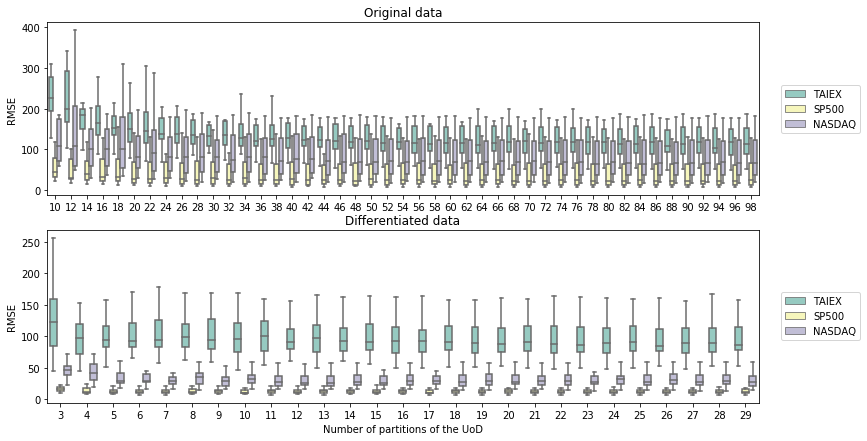

In [0]:
from pyFTS.benchmarks import Util as bUtil

df1 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'chen_partitioning' and measure = 'rmse'and transformation is null")

df2 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'chen_partitioning' and measure = 'rmse' and transformation is not null")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,7])

g1 = sns.boxplot(x='Partitions', y='Value', hue='Dataset', data=df1, showfliers=False, ax=ax[0], 
                 palette="Set3")
box = g1.get_position()
g1.set_position([box.x0, box.y0, box.width * 0.85, box.height]) 
g1.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1)
ax[0].set_title("Original data")
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("")

g2 = sns.boxplot(x='Partitions', y='Value', hue='Dataset', data=df2, showfliers=False, ax=ax[1], 
                 palette="Set3")
box = g2.get_position()
g2.set_position([box.x0, box.y0, box.width * 0.85, box.height]) 
g2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1)
ax[1].set_title("Differentiated data")
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Number of partitions of the UoD")